In [1]:
import re
import glob
import pywt

import numpy as np
import pandas as pd

import seaborn as sns
sns.set_style('darkgrid')
color = sns.color_palette()

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV


import xgboost as xgb

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
%matplotlib inline

/Users/user/opt/anaconda3/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


### Concatenate all the files

In [2]:
# get path to all files
path = 'data/spectra/simulated_data/'

files = sorted(glob.glob(path + 'model_parameters_data*.txt'), key=lambda x: int(re.search(r'\d+', x).group()))

output_path = 'data/params/'
# write_data = open(output_path + 'model_parameters_data_all_5K.txt', 'w')

# # read in all files
# for file in files:
#     with open(file, 'r') as f:
#         # skip the first 10 lines in each file
#         for i in range(10):
#             f.readline()
#         # read in the data from each file
#         data = f.readlines()
#         # write the data to the output file in the same order as the files
#         for i in range(len(data)):
#             write_data.write(data[i])

# write_data.close()  

In [3]:
# # get the params data
# df_param = pd.DataFrame()
# for file in files:
#     # get the parameters used
#     df_param = df_param.append(pd.read_csv(file, skiprows=1, nrows=6, header=None, sep=' ', names=['A', 'B', 'C', 'D']))
#     # save the dataframe to a csv file
# df_param.to_csv(output_path + 'model_parameters_data_5K.csv', index=False)

#### Load the files 

In [4]:
df_data = pd.read_csv(output_path + 'model_parameters_data_all_5K.txt', sep=' ', header=None) # all data dataframe
df_data.head()

0    1
0  238.60000  0.0
1  238.60001  0.0
2  238.60002  0.0
3  238.60003  0.0
4  238.60004  0.0

In [5]:
df_data.shape

(290000000, 2)

In [6]:
df_param = pd.read_csv(output_path + 'model_parameters_data_5K.csv')
df_param.head()

A  B             C     D
0  tcmb  =  2.730000e+00     K
1  ntot  =  2.773064e+16  cm-2
2   tex  =  1.690173e+02     K
3  fwhm  =  3.112676e+00  km/s
4  vlsr  = -1.956408e+01  km/s

In [7]:
# drop the second and fourth column
df_param.drop(['B', 'D'], axis=1, inplace=True)

In [8]:
# transform the data to the right dataframe
df_param = df_param.assign(g = df_param.groupby('A').cumcount()).pivot(index='g', columns='A', values='C')

In [9]:
df_param.head(10)

A      fwhm          ntot      size  tcmb         tex       vlsr
g                                                               
0  3.112676  2.773064e+16  0.710253  2.73  169.017264 -19.564077
1  9.342651  1.955647e+17  0.695572  2.73  272.600295 -60.816174
2  9.151363  3.123004e+16  0.454694  2.73  174.346759  75.045256
3  5.091106  6.889321e+17  0.759882  2.73   57.943522  -8.755841
4  3.750380  5.715292e+17  1.628755  2.73  251.836359   0.157871
5  3.740907  2.593032e+16  0.949397  2.73  296.468562  57.308058
6  3.170358  1.464603e+16  0.640689  2.73  126.005706 -95.756024
7  9.308356  1.584571e+17  1.484739  2.73  140.238314  57.435281
8  2.233383  4.229655e+16  0.743680  2.73  196.960722  98.457136
9  7.359029  3.591619e+17  1.004168  2.73  397.472801 -75.044236

In [10]:
df_param.columns

Index(['fwhm', 'ntot', 'size', 'tcmb', 'tex', 'vlsr'], dtype='object', name='A')

In [11]:
columns = ['Frequency', 'Intensity']
df_data.columns = columns
df_data.shape

(290000000, 2)

In [12]:
df_data.head()

Frequency  Intensity
0  238.60000        0.0
1  238.60001        0.0
2  238.60002        0.0
3  238.60003        0.0
4  238.60004        0.0

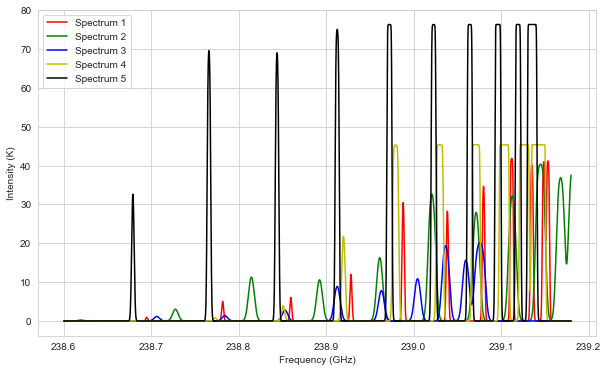

In [13]:
freq_sig = np.array(np.array_split(df_data['Frequency'], len(files)))
signal = np.array(np.array_split(df_data['Intensity'], len(files)))

# plot the signal in one plot
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")
plt.plot(freq_sig[0],  signal[0], color='r', label='Spectrum 1')
plt.plot(freq_sig[1], signal[1], color='g', label='Spectrum 2')
plt.plot(freq_sig[2], signal[2], color='b', label='Spectrum 3')
plt.plot(freq_sig[3], signal[3], color='y', label='Spectrum 4')
plt.plot(freq_sig[4], signal[4], color='k', label='Spectrum 5')
plt.xlabel("Frequency (GHz)")
plt.ylabel("Intensity (K)")
plt.legend()
plt.show()

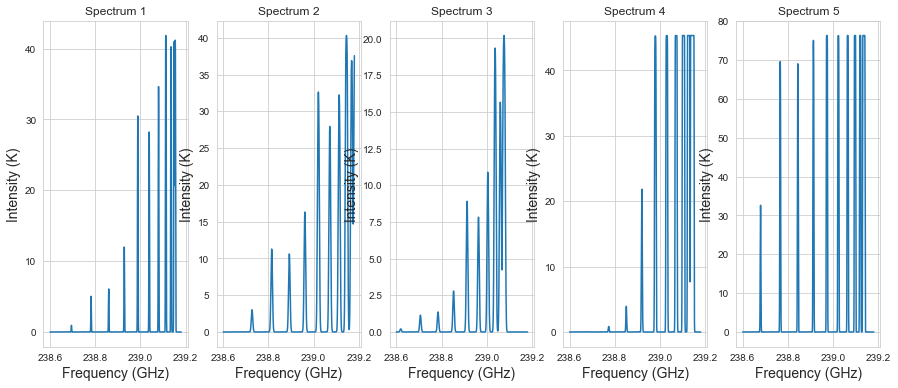

In [14]:
# plot the data in separate plots
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 6))
sns.set_style("whitegrid")
for i, ax in enumerate(axes.ravel(), start=1):
    ax.plot(freq_sig[i-1], signal[i-1], label='Spectrum {}'.format(i))
    ax.set_xlabel("Frequency (GHz)", fontdict={'fontsize': 14})
    ax.set_ylabel("Intensity (K)", fontdict={'fontsize': 14})
    ax.set_title("Spectrum {}".format(i))
    
# plt.savefig('../spectra/simulated_data/spectrum_plots.png')

In [15]:
# print(pywt.wavelist())

### Feature Extraction - Wavelet Decomposition

In [16]:
#create a  feature vector array for each spectrum 
feature_vector = np.zeros((len(signal), int(df_data.shape[0]/len(files))))
detail_coeffs = np.zeros((len(signal), 907))
approx_coeffs = np.zeros((len(signal), 907))
level = 6
wname = 'db35'
def decompose_signal_dwt(_signal, wavelet=wname, mode='per', level=level):
    """
    Performs wavelet denoising on the given signal.
    """
    # loop throuh all the spectra 
    for spectra_index in range(len(_signal)):
        # max_level = pywt.dwt_max_level(len(_signal[spectra_index]), wavelet)
        coeffs = pywt.wavedec(_signal[spectra_index], wavelet=wavelet, mode=mode, level=level)
        coeff_arr, coeff_slices = pywt.coeffs_to_array(coeffs)
        detail_coeffs[spectra_index, :] = coeff_arr[coeff_slices[1]['d']] # 4th level detail coeffs 
        # get the approximation coeffs
        approx_coeffs[spectra_index, :] = coeffs[0] # 4th level approximation coeffs
        
        reconstructed_signal = pywt.waverec(coeffs, wavelet=wavelet, mode=mode)
        feature_vector[spectra_index, :] = coeff_arr[:int(df_data.shape[0]/len(files))]
        # add the coeff_arr to the dataframe for each spectra
        # df_data['fv_dwt_{}'.format(wavelet)] = pd.Series(feature_vector.reshape(1, -1)[0], index=df_data.index) #TODO: find a way to optimize (or comment it out)
        
    return coeff_arr, coeff_slices

In [17]:
feature_vector.shape

(5000, 58000)

In [18]:
coeff_arr, coeff_slices = decompose_signal_dwt(signal)
df_data

Frequency  Intensity
0          238.60000        0.0
1          238.60001        0.0
2          238.60002        0.0
3          238.60003        0.0
4          238.60004        0.0
...              ...        ...
289999995  239.17995        0.0
289999996  239.17996        0.0
289999997  239.17997        0.0
289999998  239.17998        0.0
289999999  239.17999        0.0

[290000000 rows x 2 columns]

In [19]:
detail_coeffs.shape
detail_coeffs

array([[ 2.48523496e-24,  2.51913076e-26,  1.62009733e-28, ...,
         3.14798805e-19,  8.95111080e-21,  1.76916672e-22],
       [ 1.71278392e+01,  8.78678185e+00, -2.01868213e+01, ...,
         2.00218221e+01, -5.95784608e+00, -3.77962103e+01],
       [-4.23644224e-10,  2.88541771e-11,  1.91192819e-10, ...,
        -2.50465972e-10,  2.47582637e-10,  5.92459540e-10],
       ...,
       [ 2.83720188e-08, -2.16256536e-09, -4.56581901e-10, ...,
         3.51233534e-06, -3.49996568e-07, -7.50799804e-08],
       [-3.71344935e-03,  2.33174856e-03, -1.04231608e-03, ...,
        -2.97940017e-02,  5.64746568e-03,  2.83625596e-03],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

## Wavelet Decomposition Plots

In [20]:
def decomposed_dwt_detail_coeffs_plots(_signal, wavelet=wname, level=level):
    """
    Plots of the detail coeffs of the signal.
    """
    # plot the reconstructed signal and the original signal in one plot
    for spectra_index in range(len(_signal)):                     
        # compute the maximum useful level of decomposition for each wavelet                        
        # max_level = pywt.dwt_max_level(len(_signal[spectra_index]), wavelet)
        fig, axes = plt.subplots(nrows=1, ncols=level, dpi=400, sharey='none', sharex='all', figsize=(18, 5))
        sns.set_style("whitegrid")
        for i, ax in enumerate(axes.ravel(), start=1):
            ax.plot(coeff_arr[coeff_slices[i]['d']], label='Level {}'.format(i))
            ax.set_xlabel("Frequency (GHz)", fontdict={'fontsize': 14})
            ax.set_ylabel("Intensity (K)", fontdict={'fontsize': 14})
            ax.set_title("Spectrum {} detail coeffiecients at level {} for {} ".format(spectra_index+1, i, wavelet)) 
            
        plt.show()

In [21]:
# decomposed_dwt_detail_coeffs_plots(signal) 

In [22]:
# TODO: find a way to plot the detail coefficients of the signal
def decomposed_dwt_approx_coeffs_plots(_signal, wavelet=wname, level=level):
    
    for spectra_index in range(len(_signal)):
        fig, axes = plt.subplots(nrows=1, ncols=level, figsize=(10, 6))
        sns.set_style("whitegrid")
        for i, ax in enumerate(axes.ravel(), start=1):
            ax.plot(coeff_arr[coeff_slices[1]['d']])
            ax.set_title("Spectrum {} approximation coeffiecients at level {} for {} ".format(spectra_index+1, i,  wavelet))
            
        plt.show()

In [23]:
# decomposed_dwt_approx_coeffs_plots(signal)

### Get Features and Labels

In [24]:
# fv = np.zeros((len(signal), int(df.shape[0]/len(files))))
# for spectra_index in range(len(signal)):
#     # get the level 3 detail coefficients
#     detail_coeffs = coeff_arr[coeff_slices[3]['d']]

# fv  = detail_coeffs
# labels =dff

In [25]:
# len(signal)

approx_coeffs.shape

(5000, 907)

 #### Have a glimpse look at any of the signal and its generated detail and approximation coefficients 

In [26]:

# for spectra_index in range(len(signal)):                     
#         # compute the maximum useful level of decomposition for each wavelet                        
#         # max_level = pywt.dwt_max_level(len(_signal[spectra_index]), wavelet)
#         fig, axes = plt.subplots(nrows=1, ncols=10, sharey='none', sharex='all', figsize=(20, 7))
#         sns.set_style("whitegrid")
#         for i, ax in enumerate(axes.ravel(), start=1):
#             ax.plot(signal[spectra_index], label='Spectrum {}'.format(spectra_index))
#             # ax.set_xlabel("Frequency (GHz)", fontdict={'fontsize': 14})
#             # ax.set_ylabel("Intensity (K)", fontdict={'fontsize': 14})
#             # ax.set_title("Spectrum {} detail coeffiecients at level {} for {} ".format(spectra_index+1, i, wavelet)) 

#     # ax[0,1].plot(signal[spectra_index], label='original')
#     # ax[1,1].plot(approx_coeffs[spectra_index], label='spectrum {} approx coeff'.format(spectra_index+1))
#     # ax[2,1].plot(detail_coeffs[spectra_index], label='spectrum {} detail coeff'.format(spectra_index+1))
# plt.legend()
# plt.show()

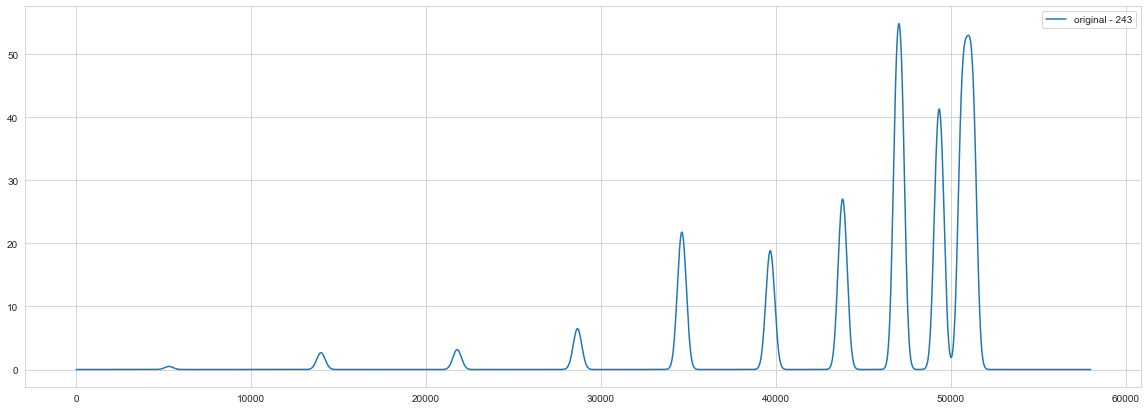

In [27]:
plt.figure(figsize=(20,7))
plt.plot(signal[243], label='original - 243')
plt.legend()
plt.savefig("data/5K_gen_files/original.png")
plt.show()

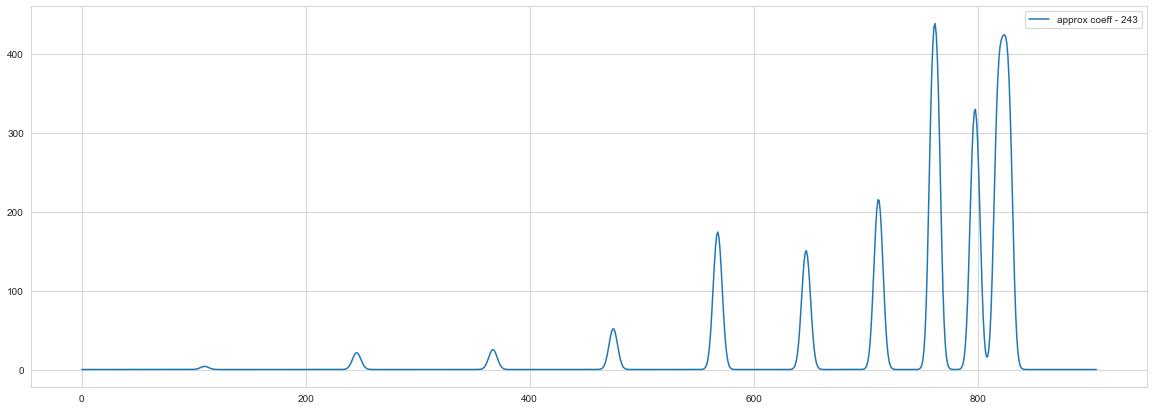

In [28]:
plt.figure(figsize=(20,7))
plt.plot(approx_coeffs[243], label='approx coeff - 243')
plt.legend()
plt.savefig("data/5K_gen_files/approx_level6.png")
plt.show()

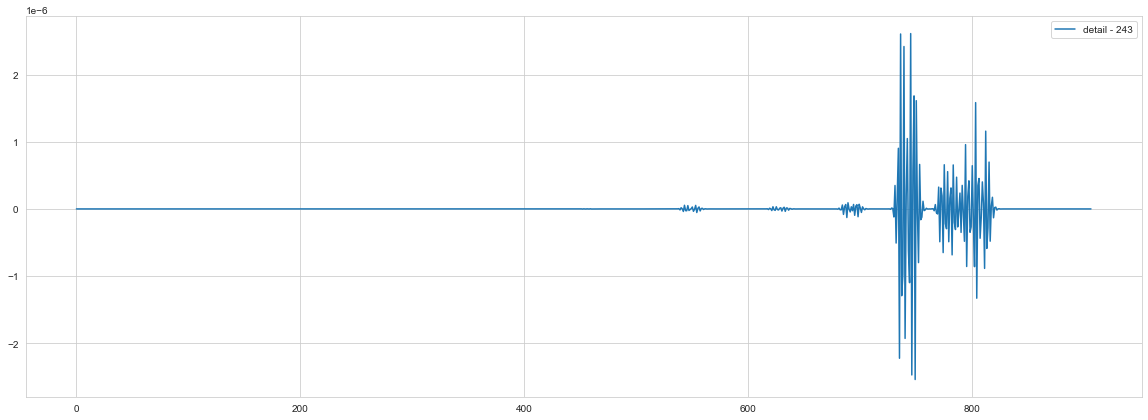

In [29]:
plt.figure(figsize=(20,7))
plt.plot(detail_coeffs[243], label='detail - 243')
plt.legend()
plt.savefig("data/5K_gen_files/detail_level6.png")
plt.show()

In [30]:
features = detail_coeffs
labels_ = df_param

print('feature_shape: ', features.shape, 'labels_shape: ', labels_.shape)


feature_shape:  (5000, 907) labels_shape:  (5000, 6)


In [31]:
# drop the tcmb column
labels_.drop(columns=['tcmb'], inplace=True)

#### save the true params to a file

In [32]:
# get the last 1500 data of the parameters from labels 
df_param = df_param.iloc[-1500:, :]
# save the vals to a csv file
df_param.to_csv("data/5K_gen_files/true_param_vals.csv")
df_param.head()


A         fwhm          ntot      size         tex        vlsr
g                                                             
3500  5.170027  5.329022e+16  0.430934  222.574567  121.413268
3501  7.427124  1.035350e+17  1.494635  348.038068  -91.901081
3502  9.394065  1.600052e+16  0.730652  288.703562 -100.474999
3503  8.865057  4.859051e+16  0.252088  337.446420 -103.952756
3504  2.753342  1.512670e+17  0.832085  156.899097 -103.302267

In [33]:
df = pd.DataFrame(approx_coeffs)
df.head()

0             1             2             3             4    \
0  3.540545e-13  3.165228e-15  1.786009e-17  4.066046e-20  1.289426e-23   
1  1.737765e+02  2.070631e+02  2.359239e+02  2.581010e+02  2.749494e+02   
2  8.705185e-19  6.524620e-20 -6.843528e-18  8.861251e-17 -7.009835e-16   
3  5.949917e-20  3.721137e-23  2.042723e-28  0.000000e+00  0.000000e+00   
4  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

            5             6             7             8             9    ...  \
0  2.009505e-29  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  ...   
1  2.852122e+02  2.925835e+02  2.942254e+02  2.954676e+02  2.892815e+02  ...   
2  3.579974e-15 -1.262393e-14  3.011443e-14 -3.494372e-14 -7.849096e-14  ...   
3  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  ...   
4  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  ...   

            897           898           899           900           901  \
0  1.012463e+01  1.687745e+00  2.065007e-01  1.888261e-02  1.300780e-03   
1  2.621778e+00  3.559874e+00  6.073564e+00  1.080494e+01  1.875232e+01   
2 -1.473742e-24 -1.054007e-24  5.589278e-23 -2.173366e-22 -3.319414e-22   
3  1.403024e-05  1.189985e-06  8.922110e-08  5.913407e-09  3.464413e-10   
4  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

            902           903           904           905           906  
0  6.764192e-05  2.652901e-06  7.830188e-08  1.734289e-09  2.872822e-11  
1  3.115091e+01  4.918829e+01  7.353149e+01  1.038009e+02  1.381570e+02  
2  5.271298e-21 -1.484976e-20 -1.464177e-20  2.209802e-19 -6.714454e-19  
3  1.793992e-11  8.184143e-13  3.160945e-14  8.785769e-16  1.271939e-17  
4  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  

[5 rows x 907 columns]

In [34]:
df = pd.concat([df, labels_], axis=1)
df.head()

0             1             2             3             4  \
0  3.540545e-13  3.165228e-15  1.786009e-17  4.066046e-20  1.289426e-23   
1  1.737765e+02  2.070631e+02  2.359239e+02  2.581010e+02  2.749494e+02   
2  8.705185e-19  6.524620e-20 -6.843528e-18  8.861251e-17 -7.009835e-16   
3  5.949917e-20  3.721137e-23  2.042723e-28  0.000000e+00  0.000000e+00   
4  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

              5             6             7             8             9  ...  \
0  2.009505e-29  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  ...   
1  2.852122e+02  2.925835e+02  2.942254e+02  2.954676e+02  2.892815e+02  ...   
2  3.579974e-15 -1.262393e-14  3.011443e-14 -3.494372e-14 -7.849096e-14  ...   
3  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  ...   
4  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  ...   

            902           903           904           905           906  \
0  6.764192e-05  2.652901e-06  7.830188e-08  1.734289e-09  2.872822e-11   
1  3.115091e+01  4.918829e+01  7.353149e+01  1.038009e+02  1.381570e+02   
2  5.271298e-21 -1.484976e-20 -1.464177e-20  2.209802e-19 -6.714454e-19   
3  1.793992e-11  8.184143e-13  3.160945e-14  8.785769e-16  1.271939e-17   
4  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

       fwhm          ntot      size         tex       vlsr  
0  3.112676  2.773064e+16  0.710253  169.017264 -19.564077  
1  9.342651  1.955647e+17  0.695572  272.600295 -60.816174  
2  9.151363  3.123004e+16  0.454694  174.346759  75.045256  
3  5.091106  6.889321e+17  0.759882   57.943522  -8.755841  
4  3.750380  5.715292e+17  1.628755  251.836359   0.157871  

[5 rows x 912 columns]

In [35]:
df.shape

(5000, 912)

#### Filter the data ----> VSLR > - 60 km/s

In [ ]:
# drop the values less than -60 in the vlsr column
# df = df.drop(df[df['vlsr'] < -60].index)
df = df[df['vlsr']>-60].reset_index(drop=True)
df.head()

In [ ]:
# get the last 1104 data of the parameters from labels 
df_param = df.iloc[-1104:, -5:]
# save the vals to a csv file
df_param.to_csv("data/5K_gen_files/true_param_vals_less.csv")
df_param.head()

In [36]:
# convert the ntot column to log values 
df['ntot'] = np.log10(df['ntot'])
df.head()

0             1             2             3             4  \
0  3.540545e-13  3.165228e-15  1.786009e-17  4.066046e-20  1.289426e-23   
1  1.737765e+02  2.070631e+02  2.359239e+02  2.581010e+02  2.749494e+02   
2  8.705185e-19  6.524620e-20 -6.843528e-18  8.861251e-17 -7.009835e-16   
3  5.949917e-20  3.721137e-23  2.042723e-28  0.000000e+00  0.000000e+00   
4  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

              5             6             7             8             9  ...  \
0  2.009505e-29  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  ...   
1  2.852122e+02  2.925835e+02  2.942254e+02  2.954676e+02  2.892815e+02  ...   
2  3.579974e-15 -1.262393e-14  3.011443e-14 -3.494372e-14 -7.849096e-14  ...   
3  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  ...   
4  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  ...   

            902           903           904           905           906  \
0  6.764192e-05  2.652901e-06  7.830188e-08  1.734289e-09  2.872822e-11   
1  3.115091e+01  4.918829e+01  7.353149e+01  1.038009e+02  1.381570e+02   
2  5.271298e-21 -1.484976e-20 -1.464177e-20  2.209802e-19 -6.714454e-19   
3  1.793992e-11  8.184143e-13  3.160945e-14  8.785769e-16  1.271939e-17   
4  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

       fwhm       ntot      size         tex       vlsr  
0  3.112676  16.442960  0.710253  169.017264 -19.564077  
1  9.342651  17.291291  0.695572  272.600295 -60.816174  
2  9.151363  16.494573  0.454694  174.346759  75.045256  
3  5.091106  17.838176  0.759882   57.943522  -8.755841  
4  3.750380  17.757038  1.628755  251.836359   0.157871  

[5 rows x 912 columns]

In [37]:
X = df.iloc[:, :907]
y = df.iloc[:, -5:]

In [38]:
X

0             1             2             3             4    \
0     3.540545e-13  3.165228e-15  1.786009e-17  4.066046e-20  1.289426e-23   
1     1.737765e+02  2.070631e+02  2.359239e+02  2.581010e+02  2.749494e+02   
2     8.705185e-19  6.524620e-20 -6.843528e-18  8.861251e-17 -7.009835e-16   
3     5.949917e-20  3.721137e-23  2.042723e-28  0.000000e+00  0.000000e+00   
4     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
...            ...           ...           ...           ...           ...   
4995  2.875532e+01  1.229383e+01  4.732281e+00  1.664402e+00  5.393384e-01   
4996  1.750675e-06  9.076227e-09  2.351109e-11  2.916677e-14  1.642891e-17   
4997  3.554326e+02  3.110571e+02  1.780775e+02  6.299689e+01  1.408570e+01   
4998  2.860564e-01 -4.114560e-01  6.362410e-01 -1.064161e+00  1.862787e+00   
4999  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

               5             6             7             8             9    \
0     2.009505e-29  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
1     2.852122e+02  2.925835e+02  2.942254e+02  2.954676e+02  2.892815e+02   
2     3.579974e-15 -1.262393e-14  3.011443e-14 -3.494372e-14 -7.849096e-14   
3     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
4     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
...            ...           ...           ...           ...           ...   
4995  1.616986e-01  4.494140e-02  1.158952e-02  2.774272e-03  6.165106e-04   
4996  3.282457e-21  4.634105e-26  1.474250e-36  0.000000e+00  0.000000e+00   
4997  2.067087e+00  2.058436e-01  1.422110e-02  6.884494e-04  2.337634e-05   
4998 -3.031555e+00  2.197731e+00  3.885042e+01  6.202491e+01  7.424703e+01   
4999  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

      ...           897           898           899           900  \
0     ...  1.012463e+01  1.687745e+00  2.065007e-01  1.888261e-02   
1     ...  2.621778e+00  3.559874e+00  6.073564e+00  1.080494e+01   
2     ... -1.473742e-24 -1.054007e-24  5.589278e-23 -2.173366e-22   
3     ...  1.403024e-05  1.189985e-06  8.922110e-08  5.913407e-09   
4     ...  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
...   ...           ...           ...           ...           ...   
4995  ...  1.972422e+02  1.972251e+02  1.972533e+02  1.972114e+02   
4996  ...  2.093813e+02  4.825549e+02  6.586739e+02  4.994623e+02   
4997  ...  2.741122e-01 -4.376380e-01  7.588932e-01 -1.456438e+00   
4998  ...  7.216893e-04 -2.186479e-03  5.593481e-03 -1.245346e-02   
4999  ...  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

               901           902           903           904           905  \
0     1.300780e-03  6.764192e-05  2.652901e-06  7.830188e-08  1.734289e-09   
1     1.875232e+01  3.115091e+01  4.918829e+01  7.353149e+01  1.038009e+02   
2    -3.319414e-22  5.271298e-21 -1.484976e-20 -1.464177e-20  2.209802e-19   
3     3.464413e-10  1.793992e-11  8.184143e-13  3.160945e-14  8.785769e-16   
4     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
...            ...           ...           ...           ...           ...   
4995  1.972606e+02  1.972875e+02  1.865886e+02  1.530871e+02  1.042756e+02   
4996  1.960001e+02  4.058121e+01  4.545596e+00  2.794095e-01  9.464954e-03   
4997  3.162572e+00 -5.783897e+00  4.860750e+01  1.839458e+02  2.963277e+02   
4998  2.459438e-02 -4.371526e-02  7.088192e-02 -1.064354e-01  1.509021e-01   
4999  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

               906  
0     2.872822e-11  
1     1.381570e+02  
2    -6.714454e-19  
3     1.271939e-17  
4     0.000000e+00  
...            ...  
4995  5.920470e+01  
4996  1.756221e-04  
4997  3.350160e+02  
4998 -2.074057e-01  
4999  0.000000e+00  

[5000 rows x 907 columns]

In [39]:
y

fwhm       ntot      size         tex        vlsr
0     3.112676  16.442960  0.710253  169.017264  -19.564077
1     9.342651  17.291291  0.695572  272.600295  -60.816174
2     9.151363  16.494573  0.454694  174.346759   75.045256
3     5.091106  17.838176  0.759882   57.943522   -8.755841
4     3.750380  17.757038  1.628755  251.836359    0.157871
...        ...        ...       ...         ...         ...
4995  6.752835  17.491351  0.469553  158.565096  -22.772785
4996  1.839103  16.906060  2.370908  319.611147 -117.826998
4997  2.677458  17.116868  0.753193  280.641386 -123.829875
4998  2.088797  17.560278  0.261259   13.462571  -91.191256
4999  3.509548  17.197719  1.640936  288.299881    6.484316

[5000 rows x 5 columns]

#### split the data into the training and test set

In [40]:
# split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    shuffle=False,
    random_state=42
    )

print('X_train shape: ',  X_train.shape, '\n',
    'y_train shape: ', y_train.shape, '\n',
    'X_test shape: ', X_test.shape, '\n',
    'y_test shape: ', y_test.shape)

X_train shape:  (3500, 907) 
 y_train shape:  (3500, 5) 
 X_test shape:  (1500, 907) 
 y_test shape:  (1500, 5)


## 1. Multioutput Regressor - RF

In [41]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler

# tuned model to use instantly
regr_multirf = MultiOutputRegressor(
    estimator=RandomForestRegressor(
        bootstrap='False',
        max_depth=90,
        max_features='log2',
        max_samples=0.8999999999999999,
        n_estimators=700,
        n_jobs=-1,
        random_state=7,
        verbose=2
))

# # from tuned model
# regr_multirf = MultiOutputRegressor(
#     estimator=RandomForestRegressor(
#        n_estimators=800, 
#        min_samples_split=2,
#        min_samples_leaf=1,
#        max_features='auto', 
#        max_depth=130,
#        bootstrap=True,
#        verbose=42
#     )
# )


# multioutput regressor+
regr_multirf.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


building tree 8 of 700building tree 2 of 700building tree 4 of 700
building tree 6 of 700building tree 1 of 700


building tree 3 of 700
building tree 7 of 700

building tree 5 of 700
building tree 9 of 700
building tree 10 of 700
building tree 11 of 700
building tree 12 of 700
building tree 13 of 700
building tree 14 of 700
building tree 15 of 700
building tree 16 of 700
building tree 17 of 700
building tree 18 of 700
building tree 19 of 700
building tree 20 of 700
building tree 21 of 700
building tree 22 of 700
building tree 23 of 700
building tree 24 of 700
building tree 25 of 700
building tree 26 of 700
building tree 27 of 700
building tree 28 of 700
building tree 29 of 700
building tree 30 of 700
building tree 31 of 700
building tree 32 of 700
building tree 33 of 700
building tree 34 of 700
building tree 35 of 700
building tree 36 of 700
building tree 37 of 700
building tree 38 of 700
building tree 39 of 700
building tree 40 of 700


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.1s


building tree 41 of 700
building tree 42 of 700
building tree 43 of 700
building tree 44 of 700
building tree 45 of 700
building tree 46 of 700
building tree 47 of 700
building tree 48 of 700
building tree 49 of 700
building tree 50 of 700
building tree 51 of 700
building tree 52 of 700
building tree 53 of 700
building tree 54 of 700
building tree 55 of 700
building tree 56 of 700
building tree 57 of 700
building tree 59 of 700
building tree 61 of 700
building tree 63 of 700
building tree 65 of 700
building tree 67 of 700
building tree 58 of 700
building tree 69 of 700
building tree 71 of 700
building tree 60 of 700
building tree 62 of 700
building tree 64 of 700
building tree 73 of 700
building tree 68 of 700
building tree 66 of 700
building tree 72 of 700
building tree 70 of 700
building tree 75 of 700
building tree 77 of 700
building tree 79 of 700
building tree 74 of 700
building tree 81 of 700
building tree 83 of 700
building tree 85 of 700
building tree 87 of 700
building tree 80

[Parallel(n_jobs=-1)]: Done 616 tasks      | elapsed:   10.8s


building tree 667 of 700
building tree 658 of 700
building tree 668 of 700
building tree 669 of 700
building tree 659 of 700
building tree 660 of 700
building tree 670 of 700
building tree 661 of 700
building tree 671 of 700
building tree 662 of 700
building tree 672 of 700
building tree 663 of 700
building tree 675 of 700
building tree 676 of 700
building tree 673 of 700
building tree 664 of 700
building tree 674 of 700
building tree 677 of 700
building tree 679 of 700
building tree 678 of 700
building tree 681 of 700
building tree 682 of 700
building tree 683 of 700
building tree 680 of 700
building tree 684 of 700
building tree 685 of 700
building tree 687 of 700
building tree 686 of 700
building tree 688 of 700
building tree 689 of 700
building tree 690 of 700
building tree 691 of 700
building tree 693 of 700building tree 692 of 700

building tree 694 of 700
building tree 696 of 700
building tree 695 of 700
building tree 698 of 700
building tree 700 of 700
building tree 699 of 700


[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:   11.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


building tree 5 of 700
building tree 3 of 700
building tree 6 of 700
building tree 1 of 700
building tree 2 of 700
building tree 4 of 700
building tree 7 of 700
building tree 8 of 700
building tree 9 of 700
building tree 10 of 700
building tree 11 of 700
building tree 12 of 700
building tree 13 of 700
building tree 14 of 700
building tree 15 of 700
building tree 16 of 700
building tree 17 of 700
building tree 19 of 700
building tree 21 of 700
building tree 23 of 700
building tree 25 of 700
building tree 27 of 700
building tree 29 of 700
building tree 31 of 700
building tree 18 of 700
building tree 20 of 700
building tree 22 of 700
building tree 28 of 700
building tree 26 of 700
building tree 24 of 700
building tree 30 of 700
building tree 32 of 700
building tree 33 of 700
building tree 34 of 700
building tree 35 of 700
building tree 43 of 700
building tree 37 of 700
building tree 39 of 700building tree 41 of 700

building tree 47 of 700
building tree 36 of 700
building tree 45 of 700
b

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s


building tree 78 of 700
building tree 59 of 700
building tree 63 of 700
building tree 67 of 700
building tree 71 of 700
building tree 56 of 700
building tree 75 of 700
building tree 60 of 700
building tree 64 of 700
building tree 79 of 700
building tree 68 of 700
building tree 81 of 700
building tree 72 of 700
building tree 80 of 700
building tree 85 of 700
building tree 76 of 700
building tree 89 of 700
building tree 93 of 700
building tree 82 of 700
building tree 97 of 700
building tree 101 of 700
building tree 86 of 700
building tree 90 of 700
building tree 105 of 700
building tree 83 of 700
building tree 94 of 700
building tree 109 of 700
building tree 98 of 700
building tree 87 of 700
building tree 91 of 700
building tree 102 of 700
building tree 106 of 700
building tree 84 of 700building tree 95 of 700

building tree 110 of 700
building tree 99 of 700
building tree 107 of 700
building tree 88 of 700
building tree 103 of 700
building tree 92 of 700
building tree 111 of 700
buildin

[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.6s


building tree 539 of 700
building tree 543 of 700
building tree 561 of 700
building tree 547 of 700
building tree 550 of 700
building tree 554 of 700
building tree 558 of 700
building tree 540 of 700
building tree 544 of 700
building tree 565 of 700
building tree 562 of 700
building tree 551 of 700
building tree 548 of 700
building tree 559 of 700
building tree 555 of 700
building tree 566 of 700
building tree 569 of 700
building tree 552 of 700
building tree 573 of 700
building tree 563 of 700
building tree 560 of 700
building tree 556 of 700
building tree 577 of 700
building tree 567 of 700
building tree 570 of 700
building tree 564 of 700
building tree 581 of 700
building tree 574 of 700
building tree 578 of 700
building tree 585 of 700
building tree 568 of 700
building tree 589 of 700
building tree 571 of 700
building tree 575 of 700
building tree 582 of 700
building tree 593 of 700
building tree 579 of 700
building tree 586 of 700
building tree 590 of 700
building tree 572 of 700


[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:    5.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


building tree 5 of 700building tree 7 of 700building tree 3 of 700building tree 2 of 700building tree 4 of 700
building tree 8 of 700



building tree 6 of 700

building tree 1 of 700
building tree 9 of 700
building tree 10 of 700
building tree 11 of 700
building tree 12 of 700
building tree 13 of 700
building tree 14 of 700
building tree 15 of 700
building tree 16 of 700
building tree 17 of 700
building tree 19 of 700
building tree 21 of 700
building tree 23 of 700
building tree 25 of 700
building tree 27 of 700
building tree 29 of 700
building tree 31 of 700
building tree 18 of 700
building tree 20 of 700
building tree 30 of 700
building tree 26 of 700
building tree 32 of 700
building tree 28 of 700
building tree 22 of 700
building tree 24 of 700
building tree 33 of 700
building tree 35 of 700
building tree 37 of 700
building tree 39 of 700
building tree 41 of 700
building tree 43 of 700
building tree 45 of 700
building tree 47 of 700
building tree 36 of 700
building tree 38 of 700
b

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s


building tree 66 of 700
building tree 70 of 700
building tree 74 of 700
building tree 78 of 700
building tree 55 of 700
building tree 59 of 700
building tree 51 of 700
building tree 63 of 700
building tree 67 of 700
building tree 71 of 700
building tree 75 of 700
building tree 60 of 700
building tree 79 of 700
building tree 52 of 700
building tree 64 of 700
building tree 56 of 700
building tree 68 of 700
building tree 72 of 700
building tree 80 of 700
building tree 76 of 700
building tree 81 of 700
building tree 93 of 700
building tree 89 of 700
building tree 85 of 700
building tree 97 of 700
building tree 101 of 700
building tree 109 of 700
building tree 105 of 700
building tree 82 of 700
building tree 102 of 700
building tree 90 of 700
building tree 94 of 700
building tree 98 of 700
building tree 86 of 700
building tree 106 of 700
building tree 110 of 700
building tree 83 of 700
building tree 91 of 700
building tree 103 of 700
building tree 87 of 700
building tree 95 of 700
building 

[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.8s


building tree 547 of 700
building tree 540 of 700
building tree 536 of 700
building tree 551 of 700
building tree 553 of 700
building tree 557 of 700
building tree 561 of 700
building tree 544 of 700
building tree 548 of 700
building tree 565 of 700
building tree 554 of 700
building tree 558 of 700
building tree 552 of 700
building tree 569 of 700
building tree 562 of 700
building tree 573 of 700
building tree 555 of 700
building tree 577 of 700
building tree 559 of 700
building tree 566 of 700
building tree 563 of 700
building tree 570 of 700
building tree 581 of 700
building tree 574 of 700
building tree 556 of 700
building tree 578 of 700
building tree 560 of 700
building tree 564 of 700
building tree 571 of 700
building tree 567 of 700
building tree 582 of 700
building tree 575 of 700
building tree 585 of 700
building tree 579 of 700
building tree 589 of 700
building tree 568 of 700
building tree 593 of 700
building tree 572 of 700
building tree 583 of 700
building tree 580 of 700


[Parallel(n_jobs=-1)]: Done 685 out of 700 | elapsed:    5.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:    5.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


building tree 2 of 700
building tree 1 of 700
building tree 4 of 700
building tree 3 of 700
building tree 5 of 700
building tree 6 of 700
building tree 7 of 700
building tree 8 of 700
building tree 10 of 700
building tree 9 of 700
building tree 11 of 700
building tree 12 of 700
building tree 14 of 700
building tree 13 of 700
building tree 15 of 700
building tree 16 of 700
building tree 19 of 700
building tree 17 of 700
building tree 23 of 700
building tree 21 of 700
building tree 20 of 700
building tree 18 of 700
building tree 24 of 700
building tree 22 of 700
building tree 25 of 700
building tree 29 of 700
building tree 27 of 700
building tree 31 of 700
building tree 26 of 700
building tree 28 of 700
building tree 30 of 700
building tree 33 of 700
building tree 35 of 700
building tree 32 of 700
building tree 34 of 700
building tree 36 of 700
building tree 37 of 700building tree 39 of 700

building tree 41 of 700
building tree 43 of 700
building tree 38 of 700
building tree 40 of 700
b

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s


building tree 77 of 700
building tree 51 of 700
building tree 55 of 700
building tree 66 of 700
building tree 59 of 700
building tree 70 of 700
building tree 74 of 700
building tree 63 of 700
building tree 52 of 700
building tree 78 of 700
building tree 60 of 700
building tree 56 of 700
building tree 71 of 700
building tree 67 of 700
building tree 75 of 700
building tree 64 of 700
building tree 79 of 700
building tree 72 of 700
building tree 68 of 700
building tree 76 of 700
building tree 80 of 700
building tree 81 of 700
building tree 85 of 700
building tree 89 of 700
building tree 93 of 700
building tree 82 of 700
building tree 97 of 700
building tree 86 of 700
building tree 90 of 700
building tree 101 of 700
building tree 94 of 700
building tree 83 of 700
building tree 87 of 700
building tree 98 of 700
building tree 91 of 700
building tree 105 of 700
building tree 102 of 700
building tree 95 of 700
building tree 84 of 700
building tree 88 of 700
building tree 99 of 700
building tree

[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.0s


building tree 544 of 700
building tree 548 of 700
building tree 549 of 700
building tree 553 of 700
building tree 554 of 700
building tree 550 of 700
building tree 555 of 700
building tree 551 of 700
building tree 557 of 700
building tree 556 of 700
building tree 552 of 700
building tree 569 of 700
building tree 577 of 700
building tree 561 of 700
building tree 573 of 700
building tree 565 of 700
building tree 558 of 700
building tree 562 of 700
building tree 570 of 700
building tree 574 of 700
building tree 559 of 700
building tree 578 of 700
building tree 566 of 700
building tree 563 of 700
building tree 575 of 700
building tree 571 of 700
building tree 560 of 700
building tree 579 of 700
building tree 581 of 700
building tree 585 of 700
building tree 567 of 700
building tree 576 of 700
building tree 564 of 700
building tree 580 of 700
building tree 572 of 700
building tree 568 of 700
building tree 582 of 700
building tree 586 of 700
building tree 589 of 700
building tree 583 of 700


[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:    4.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


building tree 1 of 700
building tree 4 of 700
building tree 2 of 700
building tree 3 of 700
building tree 6 of 700
building tree 5 of 700
building tree 9 of 700
building tree 7 of 700
building tree 10 of 700
building tree 11 of 700
building tree 8 of 700
building tree 13 of 700
building tree 12 of 700
building tree 14 of 700
building tree 15 of 700
building tree 16 of 700
building tree 17 of 700
building tree 19 of 700
building tree 21 of 700
building tree 23 of 700
building tree 25 of 700
building tree 18 of 700
building tree 27 of 700
building tree 29 of 700
building tree 31 of 700
building tree 20 of 700
building tree 22 of 700
building tree 24 of 700
building tree 28 of 700
building tree 26 of 700
building tree 30 of 700
building tree 32 of 700
building tree 33 of 700
building tree 34 of 700
building tree 39 of 700
building tree 35 of 700
building tree 37 of 700
building tree 43 of 700
building tree 41 of 700
building tree 45 of 700
building tree 47 of 700
building tree 36 of 700
b

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s


building tree 93 of 700
building tree 91 of 700
building tree 97 of 700
building tree 84 of 700
building tree 88 of 700
building tree 101 of 700
building tree 92 of 700
building tree 105 of 700
building tree 94 of 700
building tree 109 of 700
building tree 98 of 700
building tree 113 of 700
building tree 102 of 700
building tree 95 of 700
building tree 106 of 700
building tree 99 of 700
building tree 110 of 700
building tree 114 of 700
building tree 103 of 700
building tree 107 of 700
building tree 100 of 700
building tree 96 of 700
building tree 111 of 700
building tree 104 of 700
building tree 115 of 700
building tree 108 of 700
building tree 112 of 700
building tree 116 of 700
building tree 121 of 700
building tree 129 of 700
building tree 137 of 700
building tree 117 of 700
building tree 145 of 700
building tree 130 of 700
building tree 122 of 700
building tree 118 of 700
building tree 153 of 700
building tree 138 of 700
building tree 161 of 700
building tree 123 of 700
building tr

[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:    2.9s finished


MultiOutputRegressor(estimator=RandomForestRegressor(bootstrap='False',
                                                     max_depth=90,
                                                     max_features='log2',
                                                     max_samples=0.8999999999999999,
                                                     n_estimators=700,
                                                     n_jobs=-1, random_state=7,
                                                     verbose=2))

In [42]:
#  predict on the new test data
y_multirf_pred = regr_multirf.predict(X_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 700 out of 700 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 700 out of 700 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(

In [43]:
regr_multirf.score(X_test, y_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 700 out of 700 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 700 out of 700 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(

0.723665978942059

### save the predicted parameters to a csv file 

In [44]:
param_df_rf = pd.DataFrame(y_multirf_pred, columns=['fwhm_rf_pred', 'ntot_rf_pred', 'size_rf_pred', 'tex_rf_pred', 'vlsr_rf_pred'], index=X_test.index)
param_df_rf.head()

fwhm_rf_pred  ntot_rf_pred  size_rf_pred  tex_rf_pred  vlsr_rf_pred
3500      4.977598     16.629702      0.876064   286.058934    121.461160
3501      7.524141     17.116944      1.344436   300.879180    -91.732568
3502      8.852859     16.291145      0.893333   278.808339    -99.000435
3503      8.223945     16.266702      0.828723   283.549668   -103.491297
3504      3.219798     17.136760      1.243322   205.083389    -93.954669

In [45]:
# convert back the log to linear values 
param_df_rf['ntot_rf_pred'] = np.array(10**param_df_rf['ntot_rf_pred'])

In [46]:
param_df_rf.to_csv('data/5K_gen_files/predicted_parameters_rf.csv', index=True)
param_df_rf.shape

(1500, 5)

In [47]:
pred_para = pd.read_csv('data/5K_gen_files/predicted_parameters_rf.csv')
true_para = pd.read_csv('data/5K_gen_files/true_param_vals.csv')

# add the predicted value to the true value dataframe as new columns separated by an empty column 
true_para = pd.concat([true_para,  pd.DataFrame(np.zeros(len(true_para))), pred_para], axis=1)
true_para.to_csv('data/5K_gen_files/true_param_vals_with_predicted_rf.csv')
true_para.head()

g      fwhm          ntot      size         tex        vlsr    0  \
0  3500  5.170027  5.329022e+16  0.430934  222.574567  121.413268  0.0   
1  3501  7.427124  1.035350e+17  1.494635  348.038068  -91.901081  0.0   
2  3502  9.394065  1.600052e+16  0.730652  288.703562 -100.474999  0.0   
3  3503  8.865057  4.859051e+16  0.252088  337.446420 -103.952756  0.0   
4  3504  2.753342  1.512670e+17  0.832085  156.899097 -103.302267  0.0   

   Unnamed: 0  fwhm_rf_pred  ntot_rf_pred  size_rf_pred  tex_rf_pred  \
0        3500      4.977598  4.262870e+16      0.876064   286.058934   
1        3501      7.524141  1.309013e+17      1.344436   300.879180   
2        3502      8.852859  1.954990e+16      0.893333   278.808339   
3        3503      8.223945  1.847999e+16      0.828723   283.549668   
4        3504      3.219798  1.370123e+17      1.243322   205.083389   

   vlsr_rf_pred  
0    121.461160  
1    -91.732568  
2    -99.000435  
3   -103.491297  
4    -93.954669

#### Metrics

In [48]:
class RegressionMetrics:
    def __init__(self):
        self.metrics = {
            "mae": self._mean_absolute_error,
            "mse": self._mean_squared_error,
            "rmse": self._root_mean_squared_error,
            "mape": self._mean_absolute_percentage_error,
            "r2": self._r2_score,
            "msle": self._mean_squared_log_error,
            # "rmsle": self._root_mean_squared_logarithmic_error,
        }

    def get_metric(self, metric,  y_true, y_pred):
        if metric not in self.metrics:
            raise Exception("Metric not found")
        
        if metric == "mae":
            return self._mean_absolute_error(y_true, y_pred)
        if metric == "mse":
            return self._mean_squared_error(y_true, y_pred)
        if metric == "rmse":
            return self._root_mean_squared_error(y_true, y_pred)
        if metric == "mape":
            return self._mean_absolute_percentage_error(y_true, y_pred)
        if metric == "r2":
            return self._r2_score(y_true, y_pred)
        if metric == "msle":
            return self._mean_squared_log_error(y_true, y_pred)
        # if metric == "rmsle":
        #     return self._root_mean_squared_logarithmic_error(y_true, y_pred)
        
    @staticmethod
    def _mean_absolute_error(y_true, y_pred):
        return metrics.mean_absolute_error(y_true, y_pred)

    @staticmethod
    def _mean_squared_error(y_true, y_pred):
        return metrics.mean_squared_error(y_true, y_pred)

    def _root_mean_squared_error(self, y_true, y_pred):
        return np.sqrt(metrics.mean_squared_error(y_true, y_pred))

    def _mean_absolute_percentage_error(self, y_true, y_pred):
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    @staticmethod
    def _r2_score(y_true, y_pred):
        return metrics.r2_score(y_true, y_pred)
    
    def _mean_squared_log_error(self, y_true, y_pred):
        return np.sqrt(metrics.mean_squared_error(y_true, y_pred))
    
    # TODO: investigate in the case where it gives an error
    # def _root_mean_squared_logarithmic_error(self, y_true, y_pred):
    #     return np.sqrt(np.mean(np.square(np.log(y_pred + 1) - np.log(y_true + 1))))


In [49]:
# get the metricl for the multirf regressor
metrics_multirf = RegressionMetrics()
_metrics = ['mae', 'mse', 'rmse', 'mape', 'r2', 'msle']
for metric in _metrics:
    print("Multirf  {}: ".format(metric), metrics_multirf.get_metric(metric, y_test, y_multirf_pred))

Multirf  mae:  12.617327601162556
Multirf  mse:  1033.7847259702723
Multirf  rmse:  32.152522855450584
Multirf  mape:  fwhm    13.729407
ntot     1.797069
size    44.429842
tex     43.347574
vlsr     9.662339
dtype: float64
Multirf  r2:  0.723665978942059
Multirf  msle:  32.152522855450584


### Predicted vs True values plots

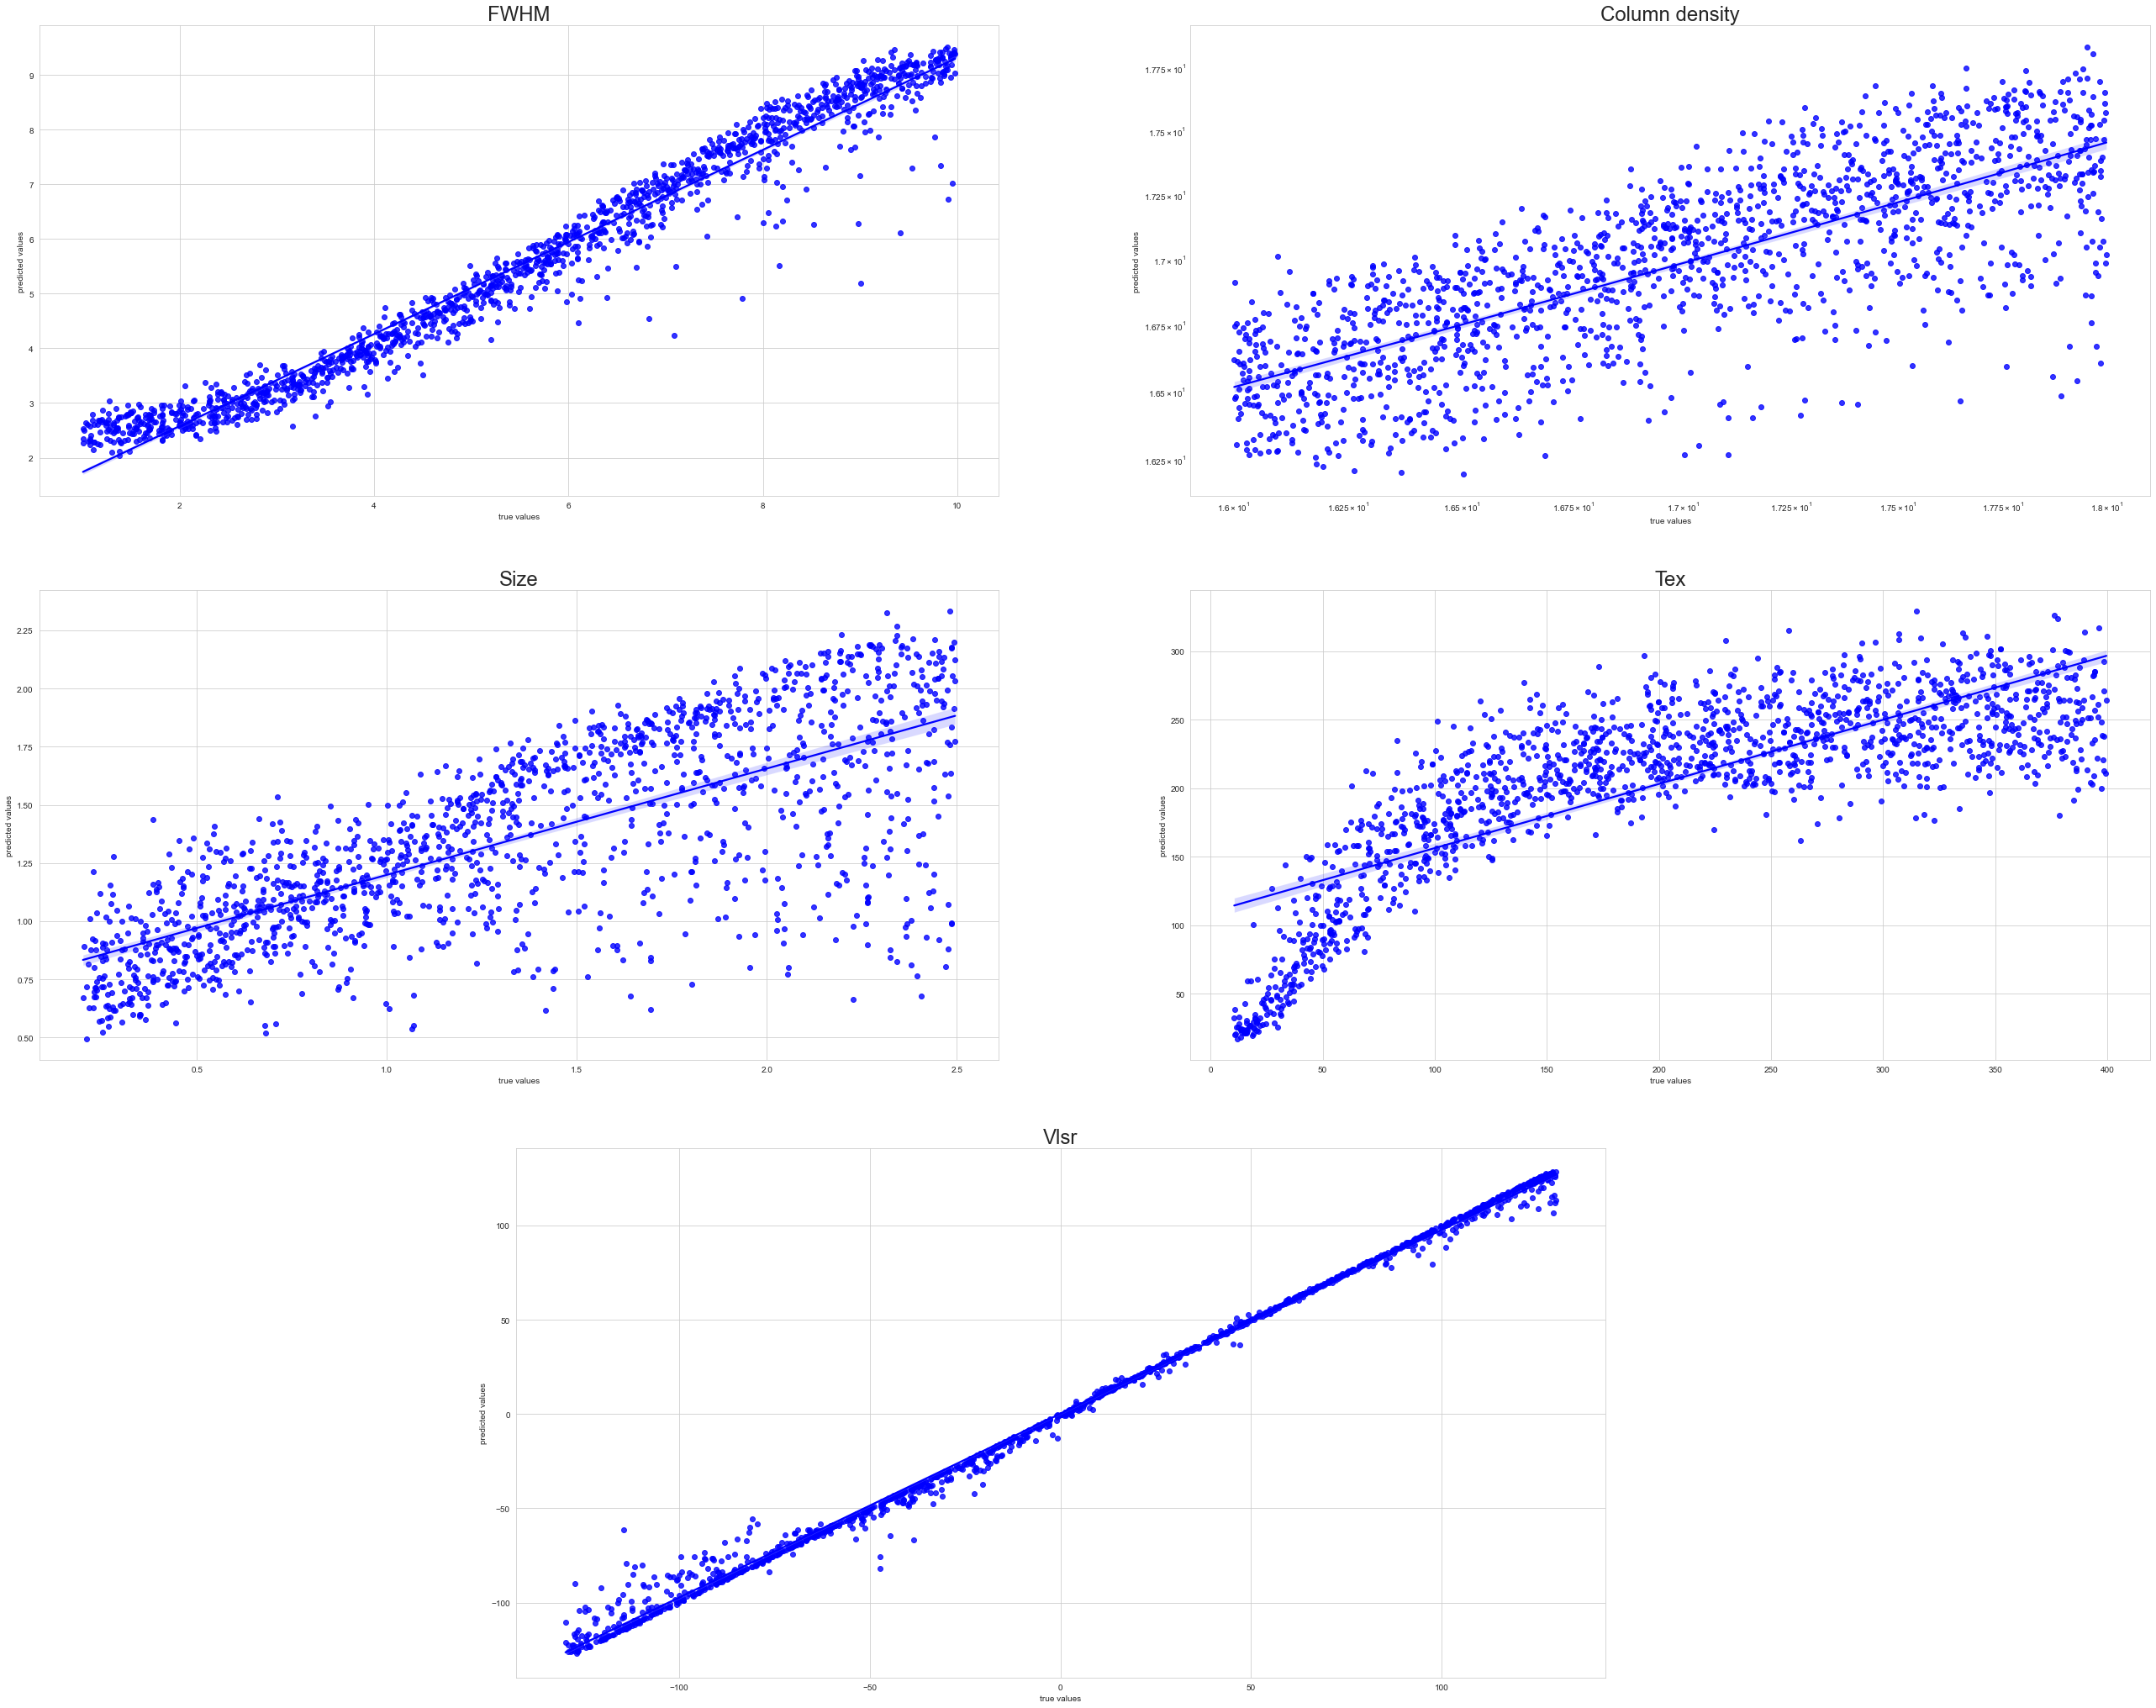

In [50]:
fig, axes = plt.subplots(3, 2, figsize=(45,35))
plt.setp(ax.get_xticklabels(), fontsize=14)
sns.set_theme(font_scale=2) 
axes[2,1].set_visible(False)
axes[2,0].set_position([0.30, 0.1,0.40,0.25])

g1 = sns.regplot(x=y_test.iloc[:,0], y=y_multirf_pred[:,0], color='blue', ax=axes[0,0]) # fwhm
g2 = sns.regplot(x=y_test.iloc[:,1], y=y_multirf_pred[:,1], color='blue', ax=axes[0,1]) # column density
g3 = sns.regplot(x=y_test.iloc[:,2], y=y_multirf_pred[:,2], color='blue', ax=axes[1,0]) # size
g4 = sns.regplot(x=y_test.iloc[:,3], y=y_multirf_pred[:,3], color='blue', ax=axes[1,1]) # tex
g5 = sns.regplot(x=y_test.iloc[:,4], y=y_multirf_pred[:,4], color='blue', ax=axes[2,0]) # vlsr

g1.set(title='FWHM', ylabel="predicted values", xlabel="true values")
g2.set(title='Column density', ylabel="predicted values", xlabel="true values", xscale='log', yscale='log')
g3.set(title='Size', ylabel="predicted values", xlabel="true values")
g4.set(title='Tex', ylabel="predicted values", xlabel="true values")
g5.set(title='Vlsr', ylabel="predicted values", xlabel="true values")

plt.savefig("data/5K_gen_files/pred_true_5K_RF.png")
plt.show()

### 3D plots -  Columnn density, Excitation temperature and Size

In [51]:
pred_param_rf = pd.DataFrame(y_multirf_pred, columns=['fwhm', 'ntot', 'size', 'tex', 'vlsr'])
pred_param_rf.head()

fwhm       ntot      size         tex        vlsr
0  4.977598  16.629702  0.876064  286.058934  121.461160
1  7.524141  17.116944  1.344436  300.879180  -91.732568
2  8.852859  16.291145  0.893333  278.808339  -99.000435
3  8.223945  16.266702  0.828723  283.549668 -103.491297
4  3.219798  17.136760  1.243322  205.083389  -93.954669

### Residuals 3D plot -  Random Forest Regressor

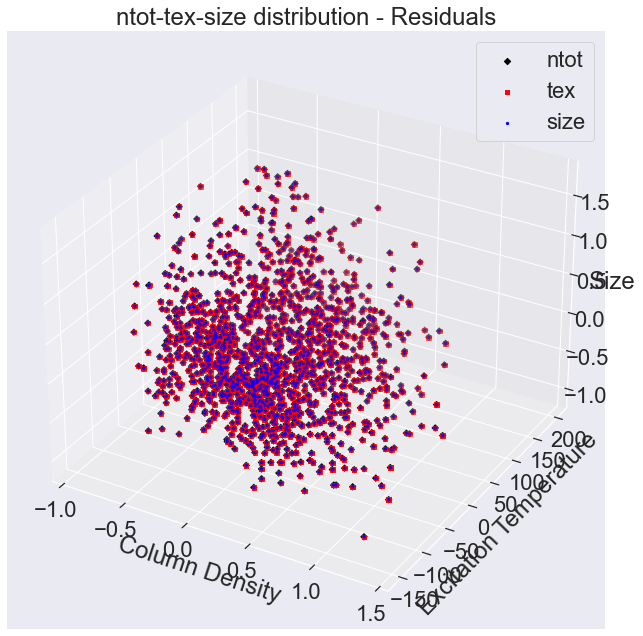

In [52]:
fig = plt.figure(figsize=(26, 11))
plt.setp(ax.get_xticklabels(), fontsize=12)
ax1 = fig.add_subplot(121, projection='3d')

markers = ['D', 's', '.']
labels = ['ntot', 'tex', 'size']
colors = ['black', 'red', 'blue']

residuals_rf = (y_test - y_multirf_pred)
# residuals
x1 = residuals_rf['ntot']
y1 = residuals_rf['tex']
z1 = residuals_rf['size']

for i in range(len(markers)):
    ax1.scatter3D(x1, y1, z1, marker=markers[i], c=colors[i], label=labels[i])

ax1.set_title('ntot-tex-size distribution - Residuals')
ax1.set_xlabel('Column Density')
ax1.set_ylabel('Excitation Temperature')
ax1.set_zlabel('Size')
plt.legend(loc="best")
plt.show()

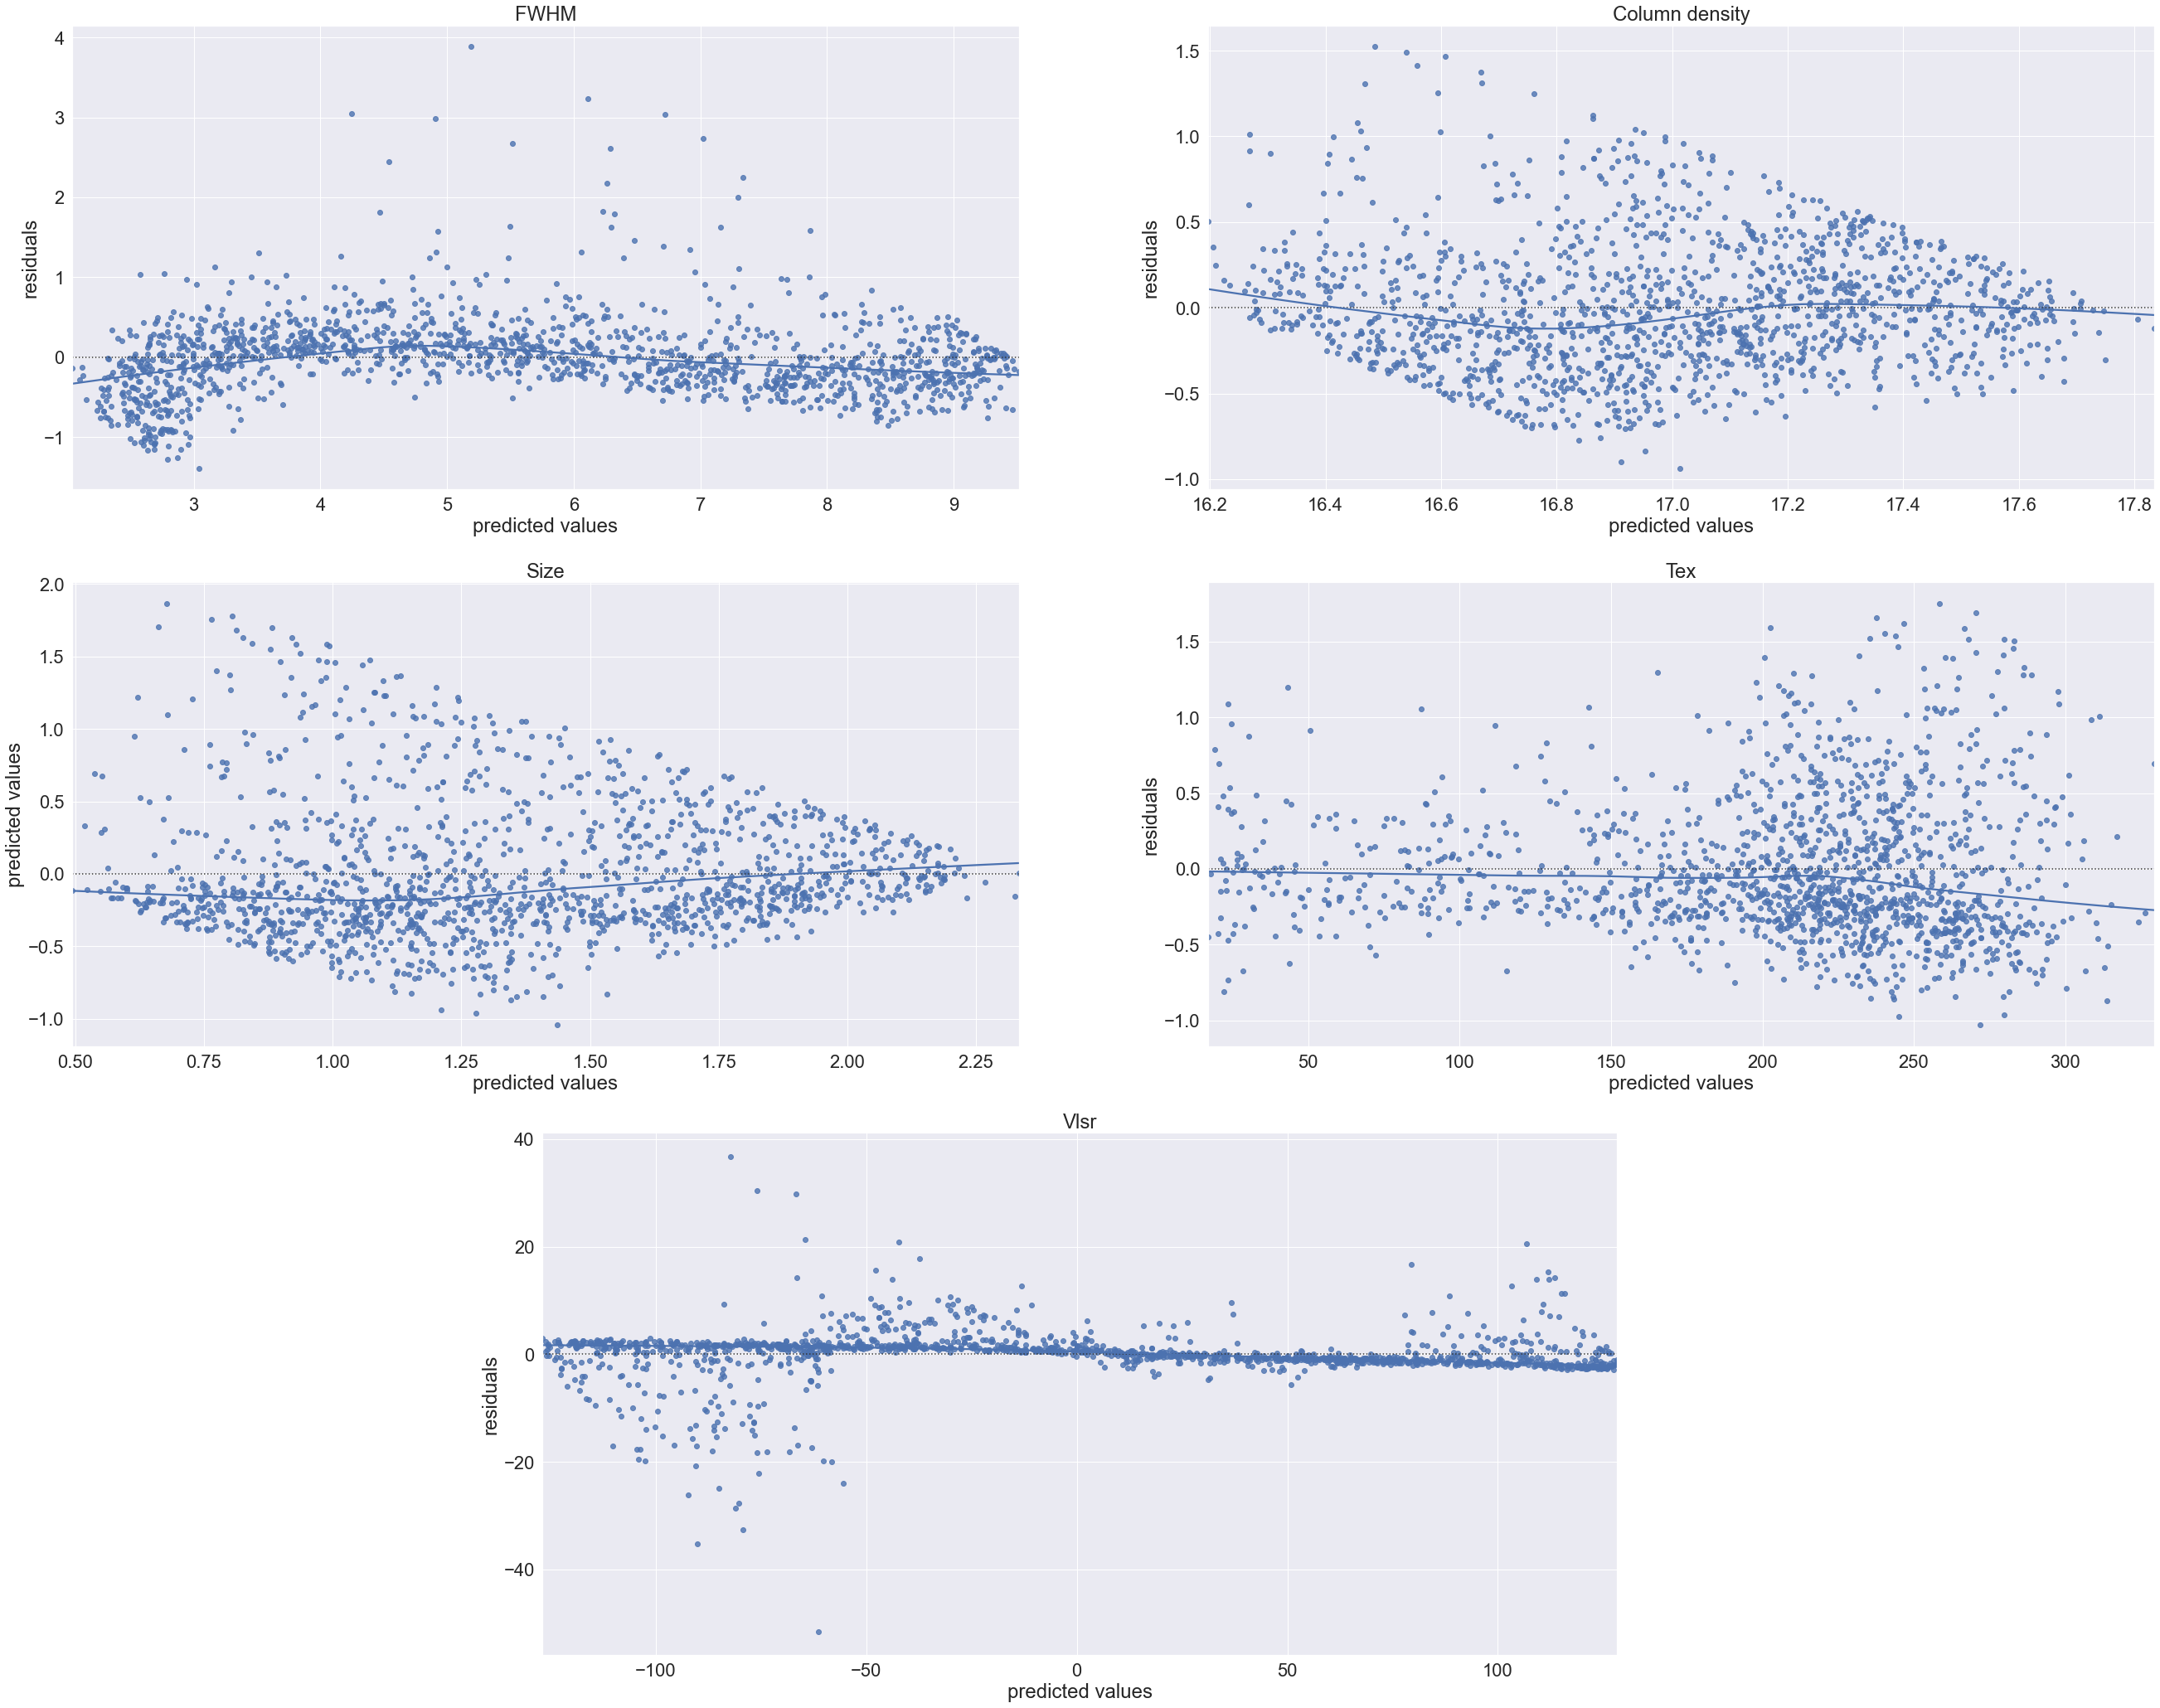

In [53]:
fig, axes = plt.subplots(3, 2, figsize=(45,35))
plt.setp(ax.get_xticklabels(), fontsize=14)
sns.set_theme(font_scale=2) 
axes[2,1].set_visible(False)
axes[2,0].set_position([0.30, 0.1,0.40,0.25])

# plot the redisual distribution using seaborn
g1 = sns.residplot(x=y_multirf_pred[:,0], y=residuals_rf['fwhm'], lowess=True, ax=axes[0,0]) # fwhm
g2 = sns.residplot(x=y_multirf_pred[:,1], y=residuals_rf['ntot'], lowess=True, ax=axes[0,1]) # column density
g3 = sns.residplot(x=y_multirf_pred[:,2], y=residuals_rf['size'], lowess=True, ax=axes[1,0]) # size
g4 = sns.residplot(x=y_multirf_pred[:,3], y=residuals_rf['size'], lowess=True, ax=axes[1,1]) # tex
g5 = sns.residplot(x=y_multirf_pred[:,4], y=residuals_rf['vlsr'], lowess=True, ax=axes[2,0]) # vlsr

g1.set(title='FWHM', ylabel="residuals", xlabel="predicted values")
g2.set(title='Column density', ylabel="residuals", xlabel="predicted values")
g3.set(title='Size', ylabel="predicted values", xlabel="predicted values")
g4.set(title='Tex', ylabel="residuals", xlabel="predicted values")
g5.set(title='Vlsr', ylabel="residuals", xlabel="predicted values")

plt.savefig("data/5K_gen_files/residuals_RF_5K.png")
plt.show()

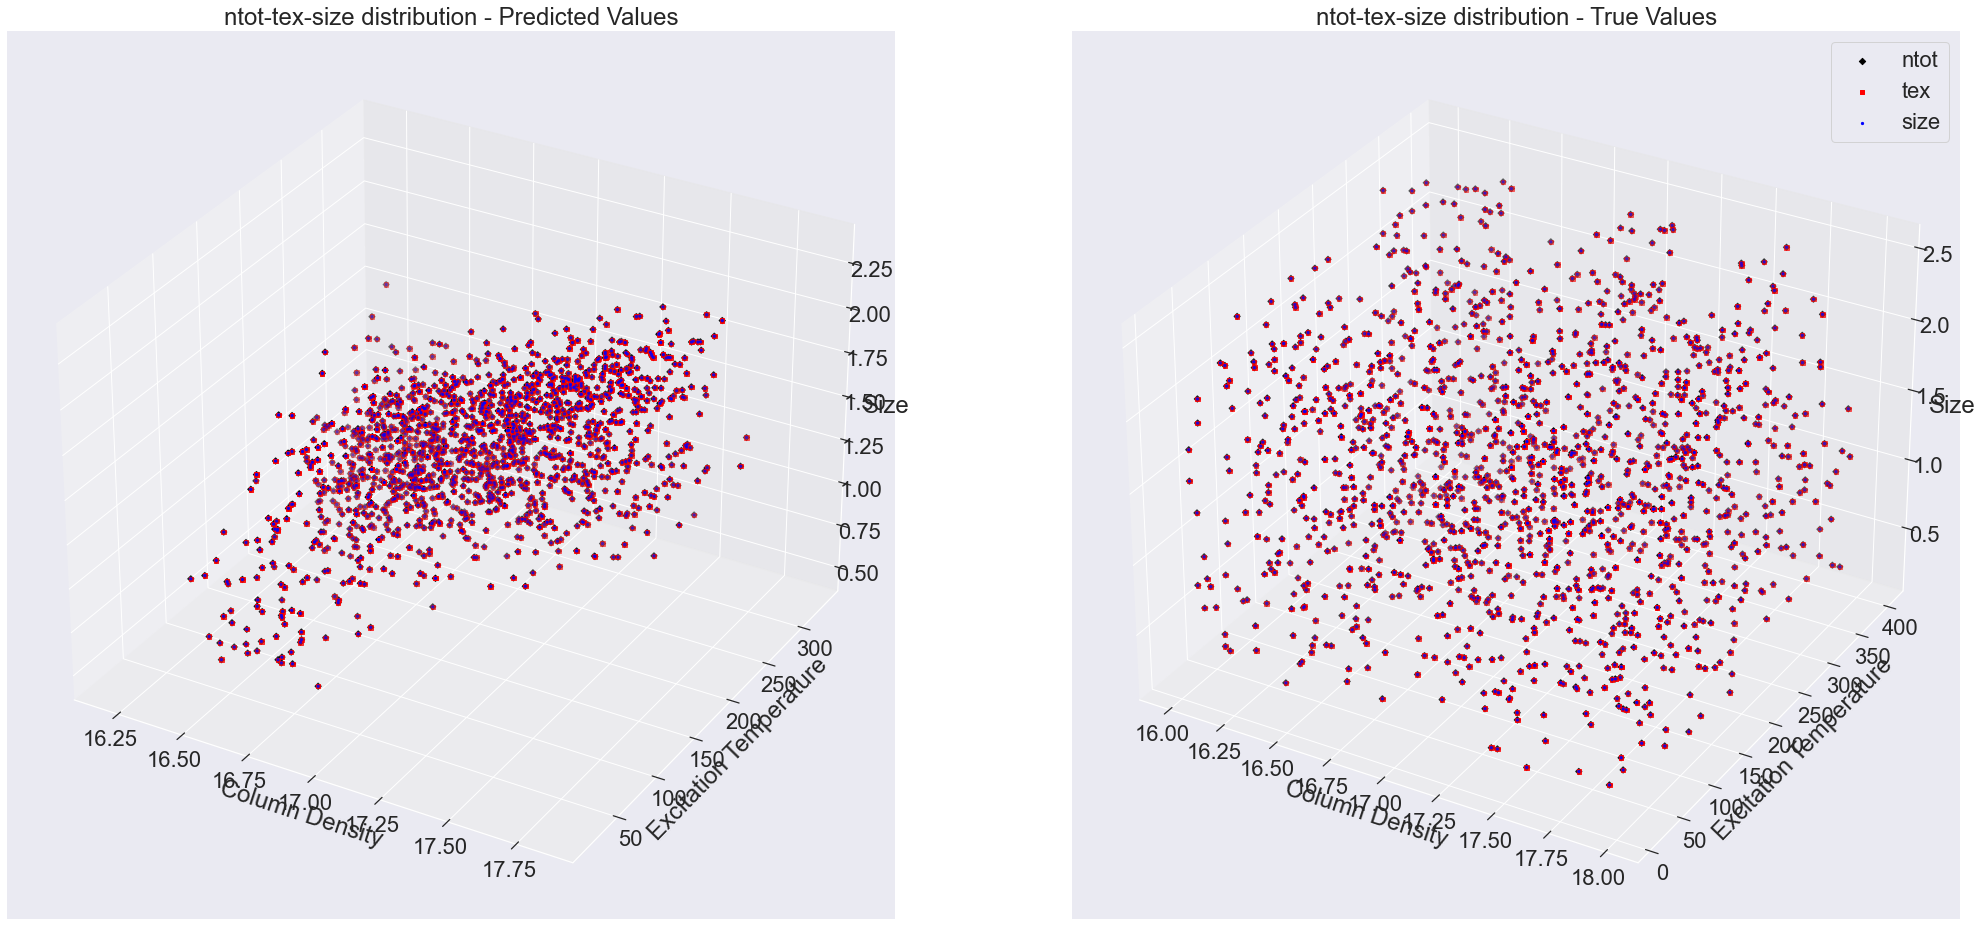

In [54]:
fig = plt.figure(figsize=(35, 25))
plt.setp(ax.get_xticklabels(), fontsize=14)
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

markers = ['D', 's', '.']
labels = ['ntot', 'tex', 'size']
colors = ['black', 'red', 'blue']

x2 = y_test['ntot']
y2 = y_test['tex']
z2 = y_test['size']


for i in range(len(markers)):
    x1 = pred_param_rf['ntot']
    y1 = pred_param_rf['tex']
    z1 = pred_param_rf['size']
    
    ax1.scatter3D(x1, y1, z1, marker=markers[i], c=colors[i], label=labels[i])
    ax2.scatter3D(x2, y2, z2, marker=markers[i], color=colors[i], label=labels[i])

ax1.set_title('ntot-tex-size distribution - Predicted Values')
ax1.set_xlabel('Column Density')
ax1.set_ylabel('Excitation Temperature')
ax1.set_zlabel('Size')


ax2.set_title('ntot-tex-size distribution - True Values')
ax2.set_xlabel('Column Density')
ax2.set_ylabel('Excitation Temperature')
ax2.set_zlabel('Size')
plt.legend(loc="best")

plt.savefig("data/5K_gen_files/scatter3D_pred_true_5K_RF.png")
plt.show()

All the points are taking up the same position in a 3D space. Not sure if this is how its supposed to be. From my understanding, the Column density is dependent on Temperature, so they take the `x`, and `y` positions while size takes the `z` position.plt

## Hyperparameter Tuning for Random Forest

In [ ]:
multirf_model = MultiOutputRegressor(
    RandomForestRegressor(
        n_estimators=100,
        max_depth=10,
        min_samples_split=2,
        min_samples_leaf=1,
        min_weight_fraction_leaf=0.0,
        criterion="squared_error",
        bootstrap=True,
        n_jobs=-1,
        max_samples=None,
))

multrf_hyperparameters = dict(
    estimator__n_estimators=np.arange(100, 1000, 100),
    estimator__max_depth=np.arange(10, 150, 10),
    estimator__min_samples_split=np.arange(2, 10, 2),
    estimator__min_samples_leaf=np.arange(1, 5, 1),
    # estimator__min_weight_fraction_leaf=np.arange(0, 0.5, 0.1),
    # estimator__criterion=["squared_error", "absolute_error"],
    estimator__max_features=["auto", "sqrt", "log2"],
    # estimator__max_samples=np.arange(0.5, 1, 0.1),
    estimator__bootstrap=["True", "False"]
    )

In [ ]:
random_search = RandomizedSearchCV(
    estimator=multirf_model,
    param_distributions=multrf_hyperparameters,
    n_iter=100,
    cv=5,
    verbose=2,
    error_score="raise",
    n_jobs=-1,
    random_state=42,
    return_train_score=True
)

In [55]:
# best parameters from tuned model
regr_tuned_multirf = MultiOutputRegressor(
    estimator=RandomForestRegressor(
       n_estimators=800, 
       min_samples_split=2,
       min_samples_leaf=1,
       max_features='auto', 
       max_depth=130,
       bootstrap=True,
       verbose=5
    )
)

In [56]:
hyper_rf_tuned_model = regr_tuned_multirf.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 800


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s


building tree 2 of 800


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.5s remaining:    0.0s


building tree 3 of 800


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.7s remaining:    0.0s


building tree 4 of 800


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    5.0s remaining:    0.0s


building tree 5 of 800
building tree 6 of 800
building tree 7 of 800
building tree 8 of 800
building tree 9 of 800
building tree 10 of 800
building tree 11 of 800
building tree 12 of 800
building tree 13 of 800
building tree 14 of 800
building tree 15 of 800
building tree 16 of 800
building tree 17 of 800
building tree 18 of 800
building tree 19 of 800
building tree 20 of 800
building tree 21 of 800
building tree 22 of 800
building tree 23 of 800
building tree 24 of 800
building tree 25 of 800
building tree 26 of 800
building tree 27 of 800
building tree 28 of 800
building tree 29 of 800
building tree 30 of 800
building tree 31 of 800
building tree 32 of 800
building tree 33 of 800
building tree 34 of 800
building tree 35 of 800
building tree 36 of 800
building tree 37 of 800
building tree 38 of 800
building tree 39 of 800
building tree 40 of 800
building tree 41 of 800
building tree 42 of 800
building tree 43 of 800
building tree 44 of 800
building tree 45 of 800
building tree 46 of 8

In [ ]:
y_multirf_tuned_rf = hyper_rf_tuned_model.predict(X_test)

In [ ]:
# print("Best hyperparameters: ", hyper_rf_tuned_model.best_params_)
# print("Best score: ", hyper_rf_tuned_model.best_score_)

Best hyperparameters:  {'estimator__n_estimators': 800, 'estimator__min_samples_split': 2, 'estimator__min_samples_leaf': 1, 'estimator__max_features': 'auto', 'estimator__max_depth': 130, 'estimator__bootstrap': 'True'}
Best score:  0.6780101270617723

In [ ]:
# tuned_rf_model = hyper_rf_tuned_model.best_estimator_
# y_multrf_tuned_tf = tuned_rf_model.predict(X_test)

In [ ]:
# # TODO: interpret the model evaluation metrics
eval = RegressionMetrics()
for metric in _metrics:
    print(metric, ":", eval.get_metric(metric, y_test, y_multirf_tuned_rf))

### True vs Predicted Values - RF Tuned Model

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(45,35))
plt.setp(ax.get_xticklabels(), fontsize=14)
sns.set_theme(font_scale=2) 
axes[2,1].set_visible(False)
axes[2,0].set_position([0.30, 0.1,0.40,0.25])

g1 = sns.regplot(x=y_test.iloc[:,0], y=y_multirf_tuned_rf[:,0], color='orange', ax=axes[0,0]) # fwhm
g2 = sns.regplot(x=y_test.iloc[:,1], y=y_multirf_tuned_rf[:,1], color='orange', ax=axes[0,1]) # column density
g3 = sns.regplot(x=y_test.iloc[:,2], y=y_multirf_tuned_rf[:,2], color='orange', ax=axes[1,0]) # size
g4 = sns.regplot(x=y_test.iloc[:,3], y=y_multirf_tuned_rf[:,3], color='orange', ax=axes[1,1]) # tex
g5 = sns.regplot(x=y_test.iloc[:,4], y=y_multirf_tuned_rf[:,4], color='orange', ax=axes[2,0]) # vlsr

g1.set(title='FWHM', ylabel="predicted values", xlabel="true values")
g2.set(title='Column density', ylabel="predicted values", xlabel="true values", xscale='log', yscale='log')
g3.set(title='Size', ylabel="predicted values", xlabel="true values")
g4.set(title='Tex', ylabel="predicted values", xlabel="true values")
g5.set(title='Vlsr', ylabel="predicted values", xlabel="true values")

plt.savefig("data/5K_gen_files/pred_true_5K_tuned_RF.png")
plt.show()

### Residuals - RF Tuned Model

In [ ]:
residuals_tuned_rf = (y_test - y_multirf_tuned_rf)
residuals_tuned_rf

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(45,35))
plt.setp(ax.get_xticklabels(), fontsize=14)
sns.set_theme(font_scale=2) 
axes[2,1].set_visible(False)
axes[2,0].set_position([0.30, 0.1,0.40,0.25])

# plot the redisual distribution using seaborn
g1 = sns.residplot(x=y_multirf_tuned_rf[:,0], y=residuals_tuned_rf['fwhm'], lowess=True, ax=axes[0,0], color='orange') # fwhm
g2 = sns.residplot(x=y_multirf_tuned_rf[:,1], y=residuals_tuned_rf['ntot'], lowess=True, ax=axes[0,1], color='orange') # column density
g3 = sns.residplot(x=y_multirf_tuned_rf[:,2], y=residuals_tuned_rf['size'], lowess=True, ax=axes[1,0], color='orange') # size
g4 = sns.residplot(x=y_multirf_tuned_rf[:,3], y=residuals_tuned_rf['size'], lowess=True, ax=axes[1,1], color='orange') # tex
g5 = sns.residplot(x=y_multirf_tuned_rf[:,4], y=residuals_tuned_rf['vlsr'], lowess=True, ax=axes[2,0], color='orange') # vlsr
g1.set(title='FWHM', ylabel="residuals", xlabel="predicted values")
g2.set(title='Column density', ylabel="residuals", xlabel="predicted values")
g3.set(title='Size', ylabel="predicted values", xlabel="predicted values")
g4.set(title='Tex', ylabel="residuals", xlabel="predicted values")
g5.set(title='Vlsr', ylabel="residuals", xlabel="predicted values")

plt.savefig("data/5K_gen_files/residuals_tuned_RF_5K.png")
plt.show()

## 2. XGBoost Regressor

In [55]:
multixgb_model = MultiOutputRegressor(
    xgb.XGBRegressor(
        n_estimators=100,
        max_depth=10,
        max_leaves=10,
        max_bin=10,
        learning_rate=0.1,
        n_jobs=-1,
        gamma=0,
        min_child_weight=1.0,
        max_delta_step=0,
        importance_type="gain",
        eval_metric=metrics.mean_squared_error
    )
)

multixgb_model.fit(X_train, y_train)

MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            enable_categorical=False,
                                            eval_metric=<function mean_squared_error at 0x7fac35448820>,
                                            gamma=0, gpu_id=None,
                                            importance_type='gain',
                                            interaction_constraints=None,
                                            learning_rate=0.1, max_bin=10,
                                            max_delta_step=0, max_depth=10,
                                            max_leaves=10, min_child_weight=1.0,
                                            missing=nan,
                                            monoton

In [56]:
y_multixgb_pred = multixgb_model.predict(X_test)

In [57]:
for metric in _metrics:
    print(metric, ":", metrics_multirf.get_metric(metric, y_test, y_multixgb_pred))

mae : 10.996731611502453
mse : 879.5010960418397
rmse : 29.656383731699986
mape : fwhm     9.620601
ntot     1.787838
size    41.914360
tex     33.465270
vlsr    15.248333
dtype: float64
r2 : 0.7363688516295218
msle : 29.656383731699986


### save the predicted parameters to a csv file

In [58]:
param_df_xgb = pd.DataFrame(y_multixgb_pred, columns=['fwhm_pred_xgb', 'ntot_pred_xgb', 'size_pred_xgb', 'tex_pred_xgb', 'vlsr_xgb_pred'])
param_df_xgb['ntot_pred_xgb'] = np.exp(param_df_xgb['ntot_pred_xgb'])
param_df_xgb.to_csv('data/5K_gen_files/predicted_parameters_xgb.csv')

In [59]:
param_df_xgb.head()

fwhm_pred_xgb  ntot_pred_xgb  size_pred_xgb  tex_pred_xgb  vlsr_xgb_pred
0       5.111128     15793297.0       0.572288    287.475098     121.576096
1       7.551797     28594912.0       1.455519    310.479370     -92.539803
2       9.296038     11909768.0       0.762068    274.045654    -100.499428
3       8.477529     12386491.0       0.736071    303.625458    -104.704201
4       2.619819     24963816.0       1.199342    218.872375    -101.182228

### Predicted vs True values - XGB Regressor

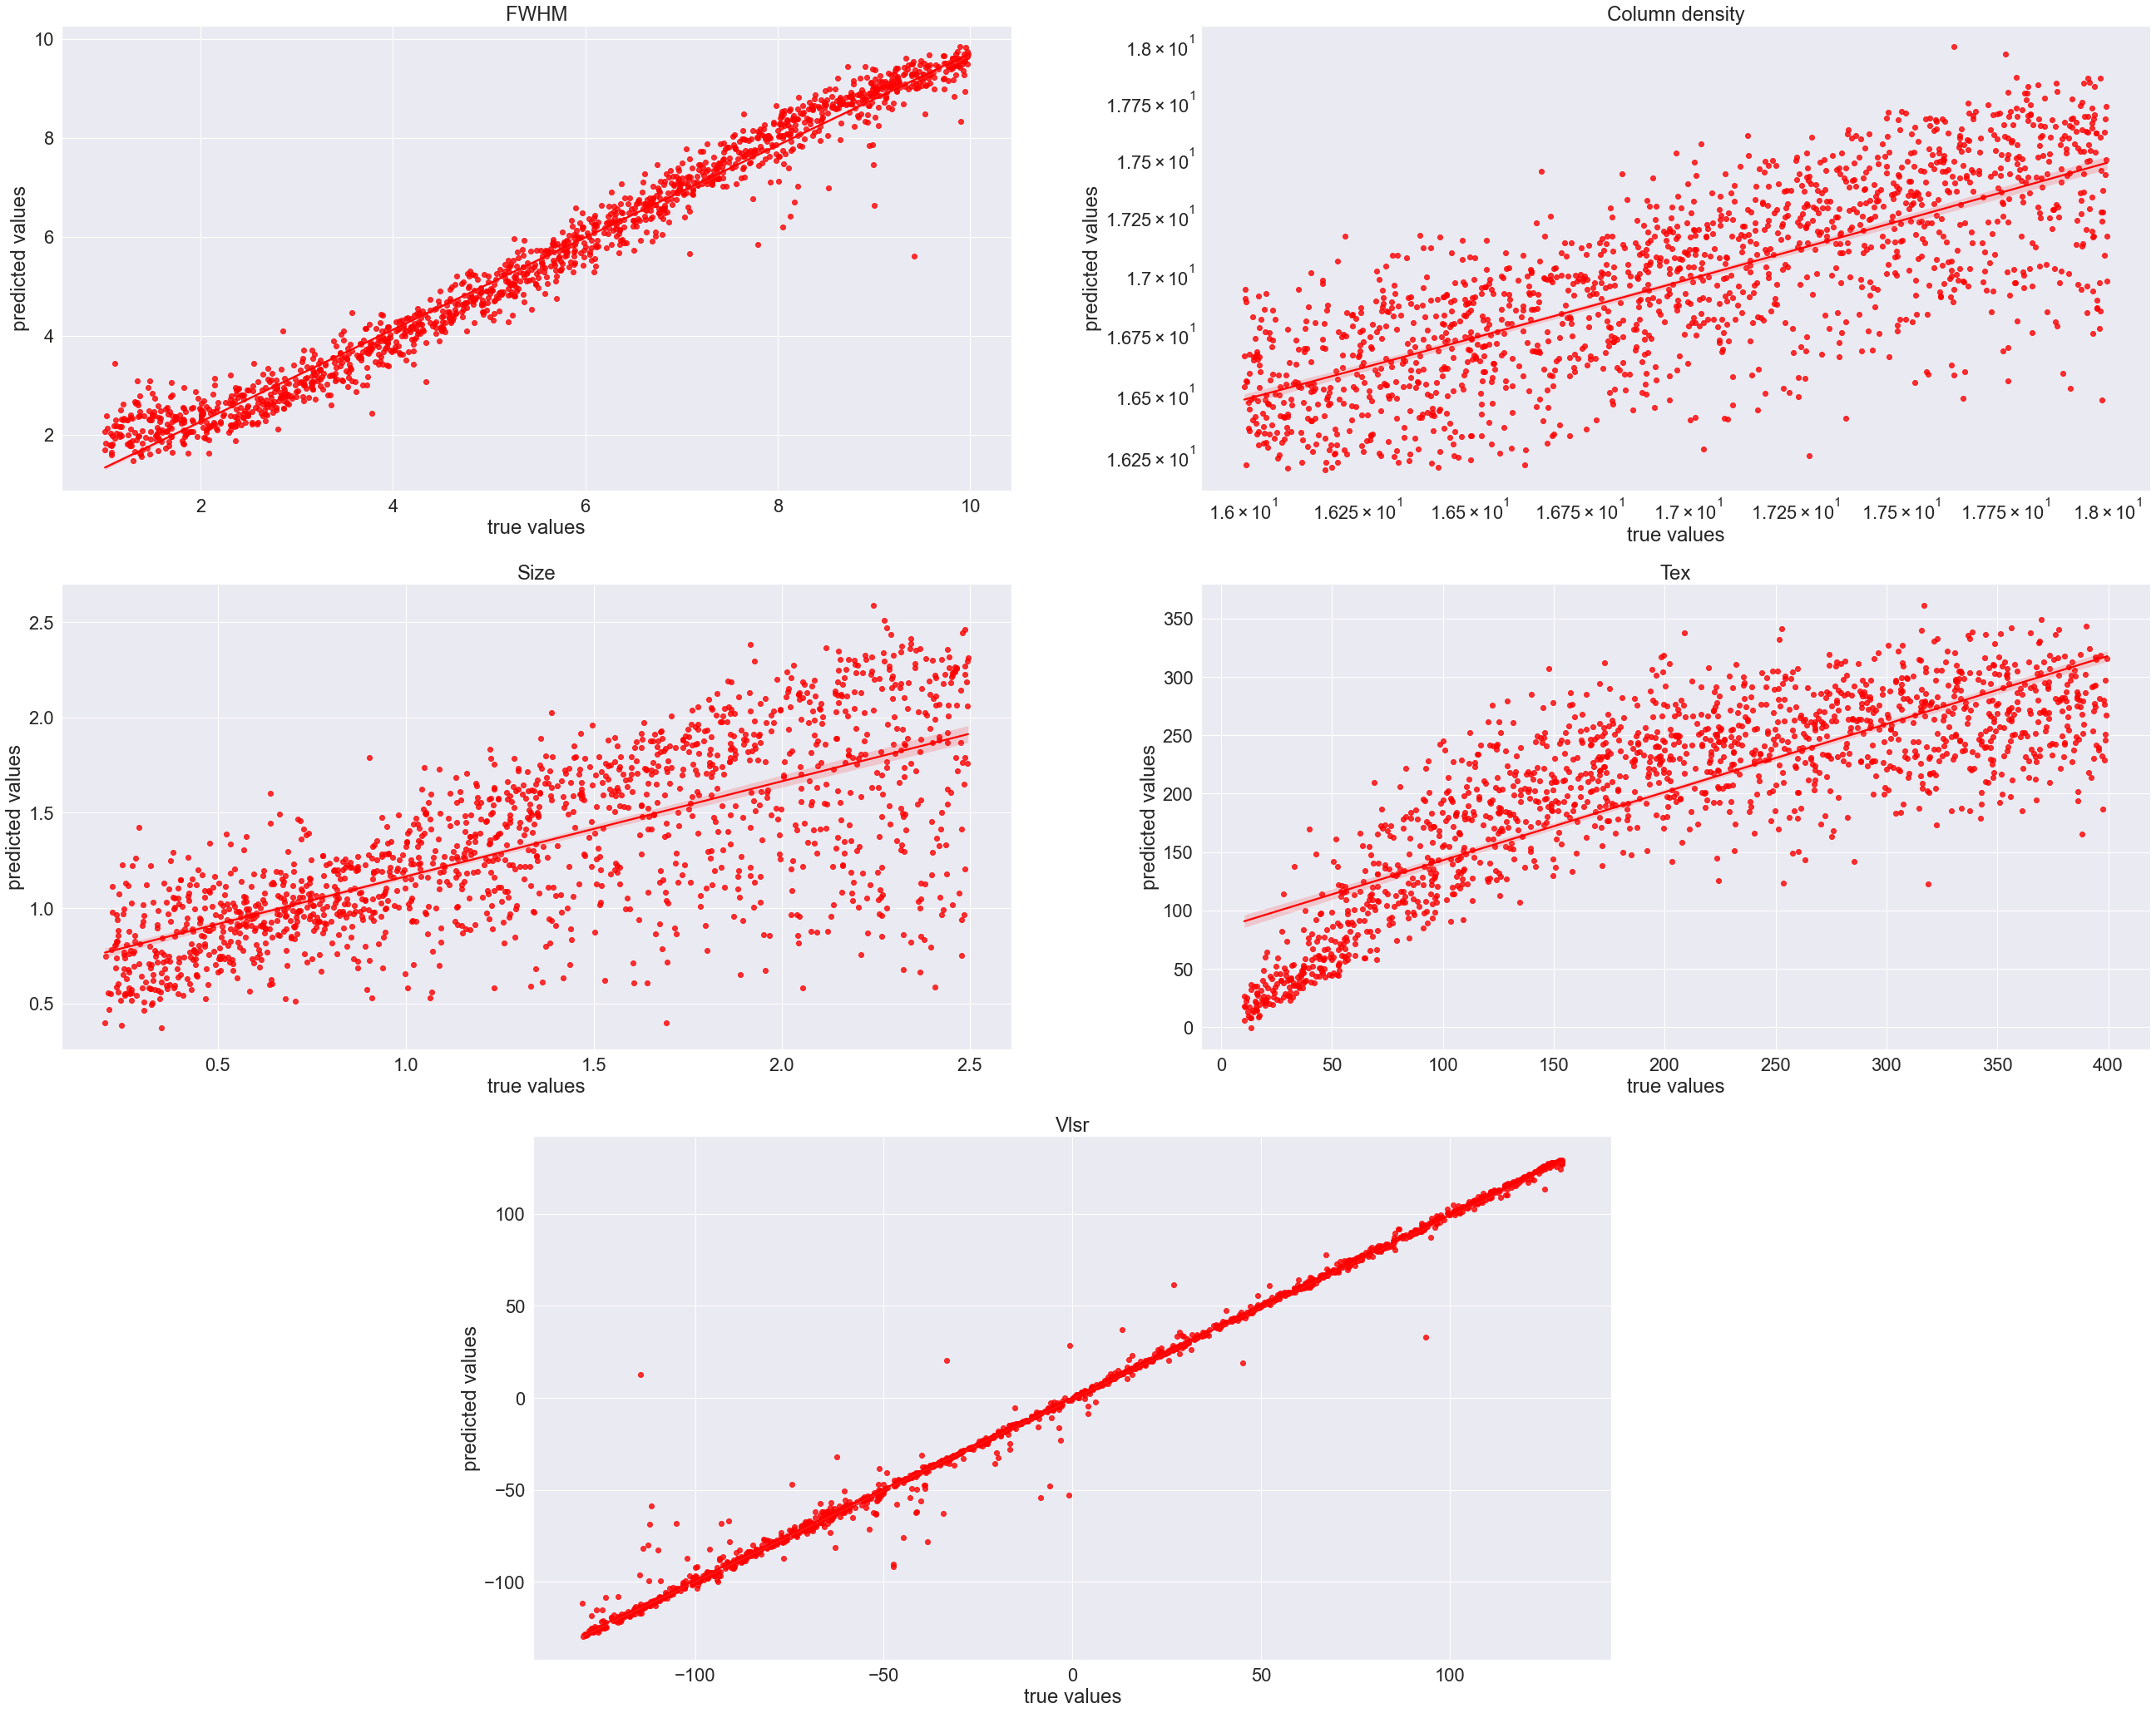

In [60]:
fig, axes = plt.subplots(3, 2, figsize=(45,35))
plt.setp(ax.get_xticklabels(), fontsize=14)
sns.set_theme(font_scale=2) 
axes[2,1].set_visible(False)
axes[2,0].set_position([0.30, 0.1,0.40,0.25])

g1 = sns.regplot(x=y_test.iloc[:, 0], y=y_multixgb_pred[:,0],color='red', ax=axes[0,0]) # fwhm
g2 = sns.regplot(x=y_test.iloc[:,1], y=y_multixgb_pred[:,1], color='red', ax=axes[0,1]) # column density
g3 = sns.regplot(x=y_test.iloc[:,2], y=y_multixgb_pred[:,2], color='red', ax=axes[1,0]) # size
g4 = sns.regplot(x=y_test.iloc[:,3], y=y_multixgb_pred[:,3], color='red', ax=axes[1,1]) # tex
g5 = sns.regplot(x=y_test.iloc[:,4], y=y_multixgb_pred[:,4], color='red', ax=axes[2,0]) # vlsr
g1.set(title='FWHM', ylabel="predicted values", xlabel="true values")
g2.set(title='Column density', ylabel="predicted values", xlabel="true values", yscale="log", xscale="log")
g3.set(title='Size', ylabel="predicted values", xlabel="true values")
g4.set(title='Tex', ylabel="predicted values", xlabel="true values")
g5.set(title='Vlsr', ylabel="predicted values", xlabel="true values")

plt.savefig("data/5K_gen_files/pred_true_5K_XGB.png")
plt.show()

### 3D plots - Columnn density, Excitation temperature and Size - XGB Regressor

In [61]:
pred_param_xgb = pd.DataFrame(y_multixgb_pred, columns=['fwhm', 'ntot', 'size', 'tex', 'vlsr'])
pred_param_xgb.head()

fwhm       ntot      size         tex        vlsr
0  5.111128  16.575096  0.572288  287.475098  121.576096
1  7.551797  17.168739  1.455519  310.479370  -92.539803
2  9.296038  16.292870  0.762068  274.045654 -100.499428
3  8.477529  16.332117  0.736071  303.625458 -104.704201
4  2.619819  17.032938  1.199342  218.872375 -101.182228

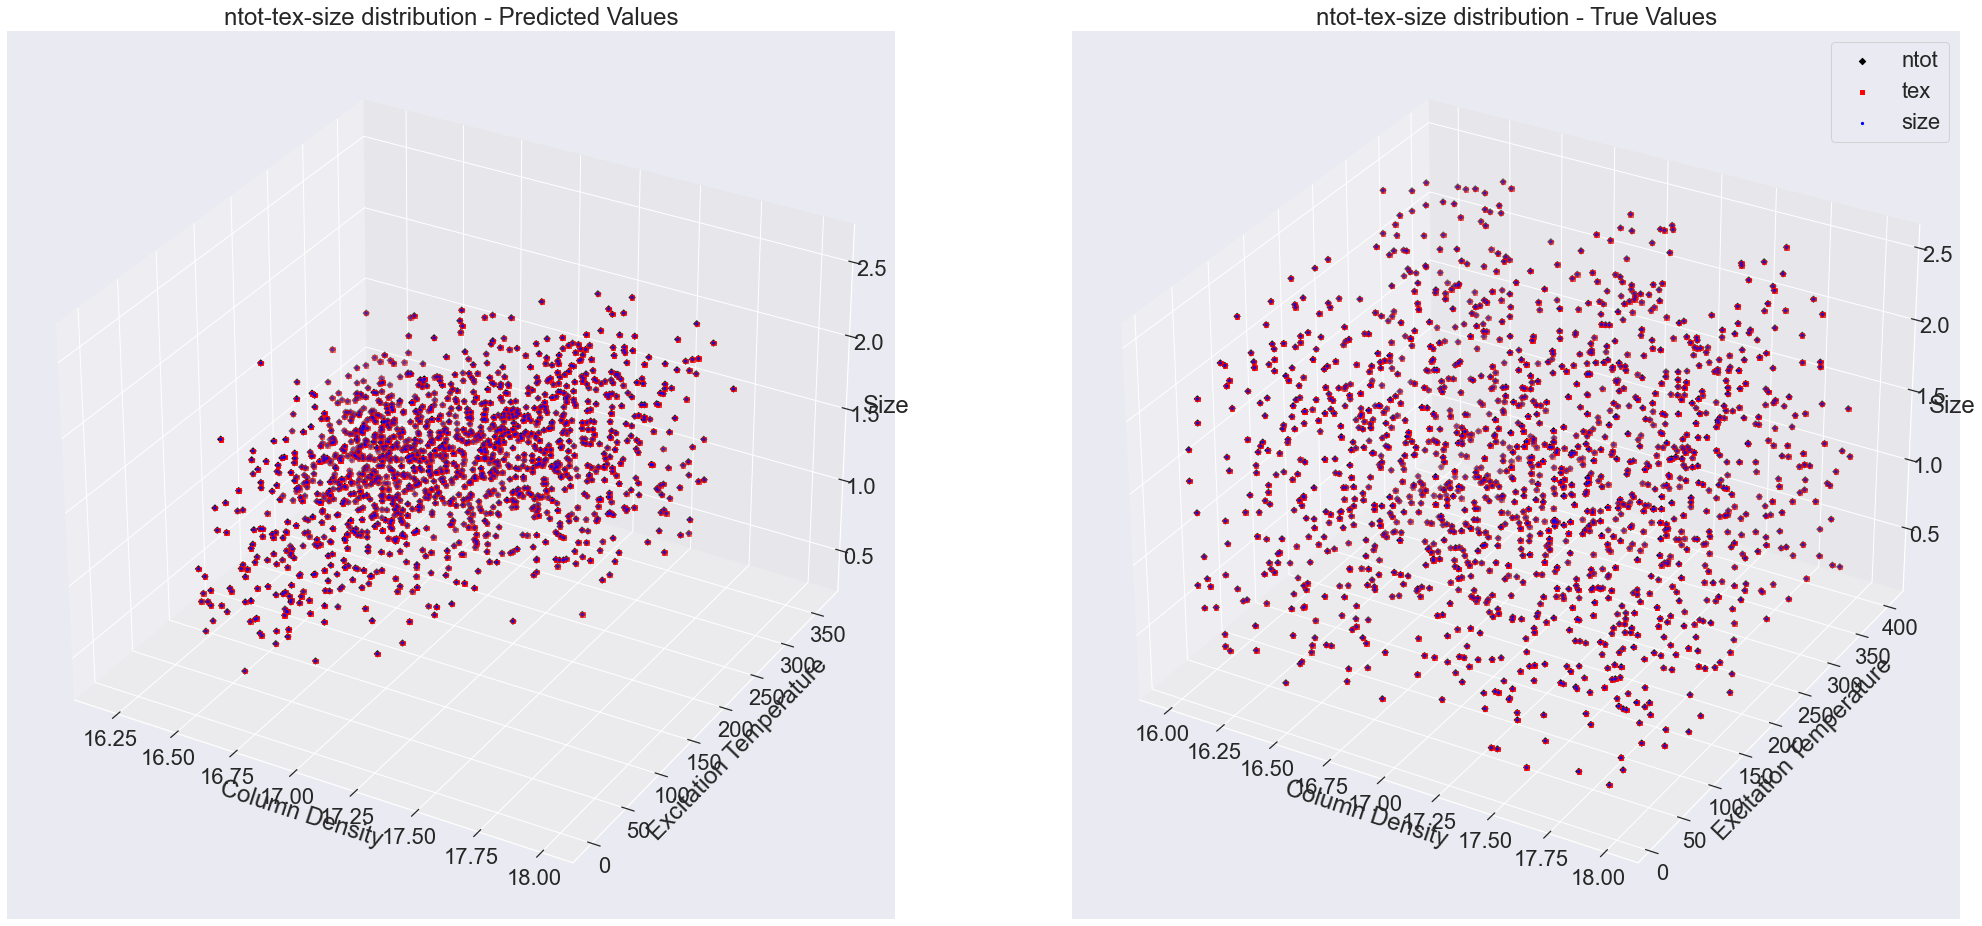

In [62]:
fig = plt.figure(figsize=(35, 25))
plt.setp(ax.get_xticklabels(), fontsize=14)
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')


markers = ['D', 's', '.']
labels = ['ntot', 'tex', 'size']
colors = ['black', 'red', 'blue']


x1 = pred_param_xgb['ntot']
y1 = pred_param_xgb['tex']
z1 = pred_param_xgb['size']
    
x2 = y_test['ntot']
y2 = y_test['tex']
z2 = y_test['size']


for i in range(len(markers)):
    ax1.scatter3D(x1, y1, z1, marker=markers[i], c=colors[i], label=labels[i])
    ax2.scatter3D(x2, y2, z2, marker=markers[i], color=colors[i], label=labels[i])

ax1.set_title('ntot-tex-size distribution - Predicted Values')
ax1.set_xlabel('Column Density')
ax1.set_ylabel('Excitation Temperature')
ax1.set_zlabel('Size')


ax2.set_title('ntot-tex-size distribution - True Values')
ax2.set_xlabel('Column Density', )
ax2.set_ylabel('Excitation Temperature')
ax2.set_zlabel('Size')
plt.legend(loc="best")

plt.savefig("data/5K_gen_files/scatter3D_pred_true_5K_XGB.png")
plt.show()

### Residuals 3D plot - XGB Regressor

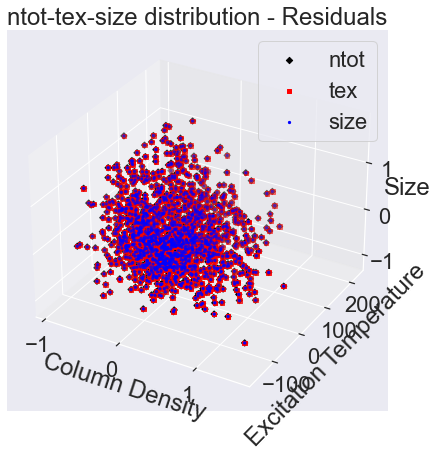

In [63]:
fig = plt.figure(figsize=(15, 7))
plt.setp(ax.get_xticklabels(), fontsize=14)
ax1 = fig.add_subplot(121, projection='3d')

markers = ['D', 's', '.']
labels = ['ntot', 'tex', 'size']
colors = ['black', 'red', 'blue']

residuals_xgb = (y_test - y_multixgb_pred)
# residuals
x1 = residuals_xgb['ntot']
y1 = residuals_xgb['tex']
z1 = residuals_xgb['size']

for i in range(len(markers)):
    ax1.scatter3D(x1, y1, z1, marker=markers[i], c=colors[i], label=labels[i])

ax1.set_title('ntot-tex-size distribution - Residuals')
ax1.set_xlabel('Column Density')
ax1.set_ylabel('Excitation Temperature')
ax1.set_zlabel('Size')
plt.legend(loc="best")
plt.show()

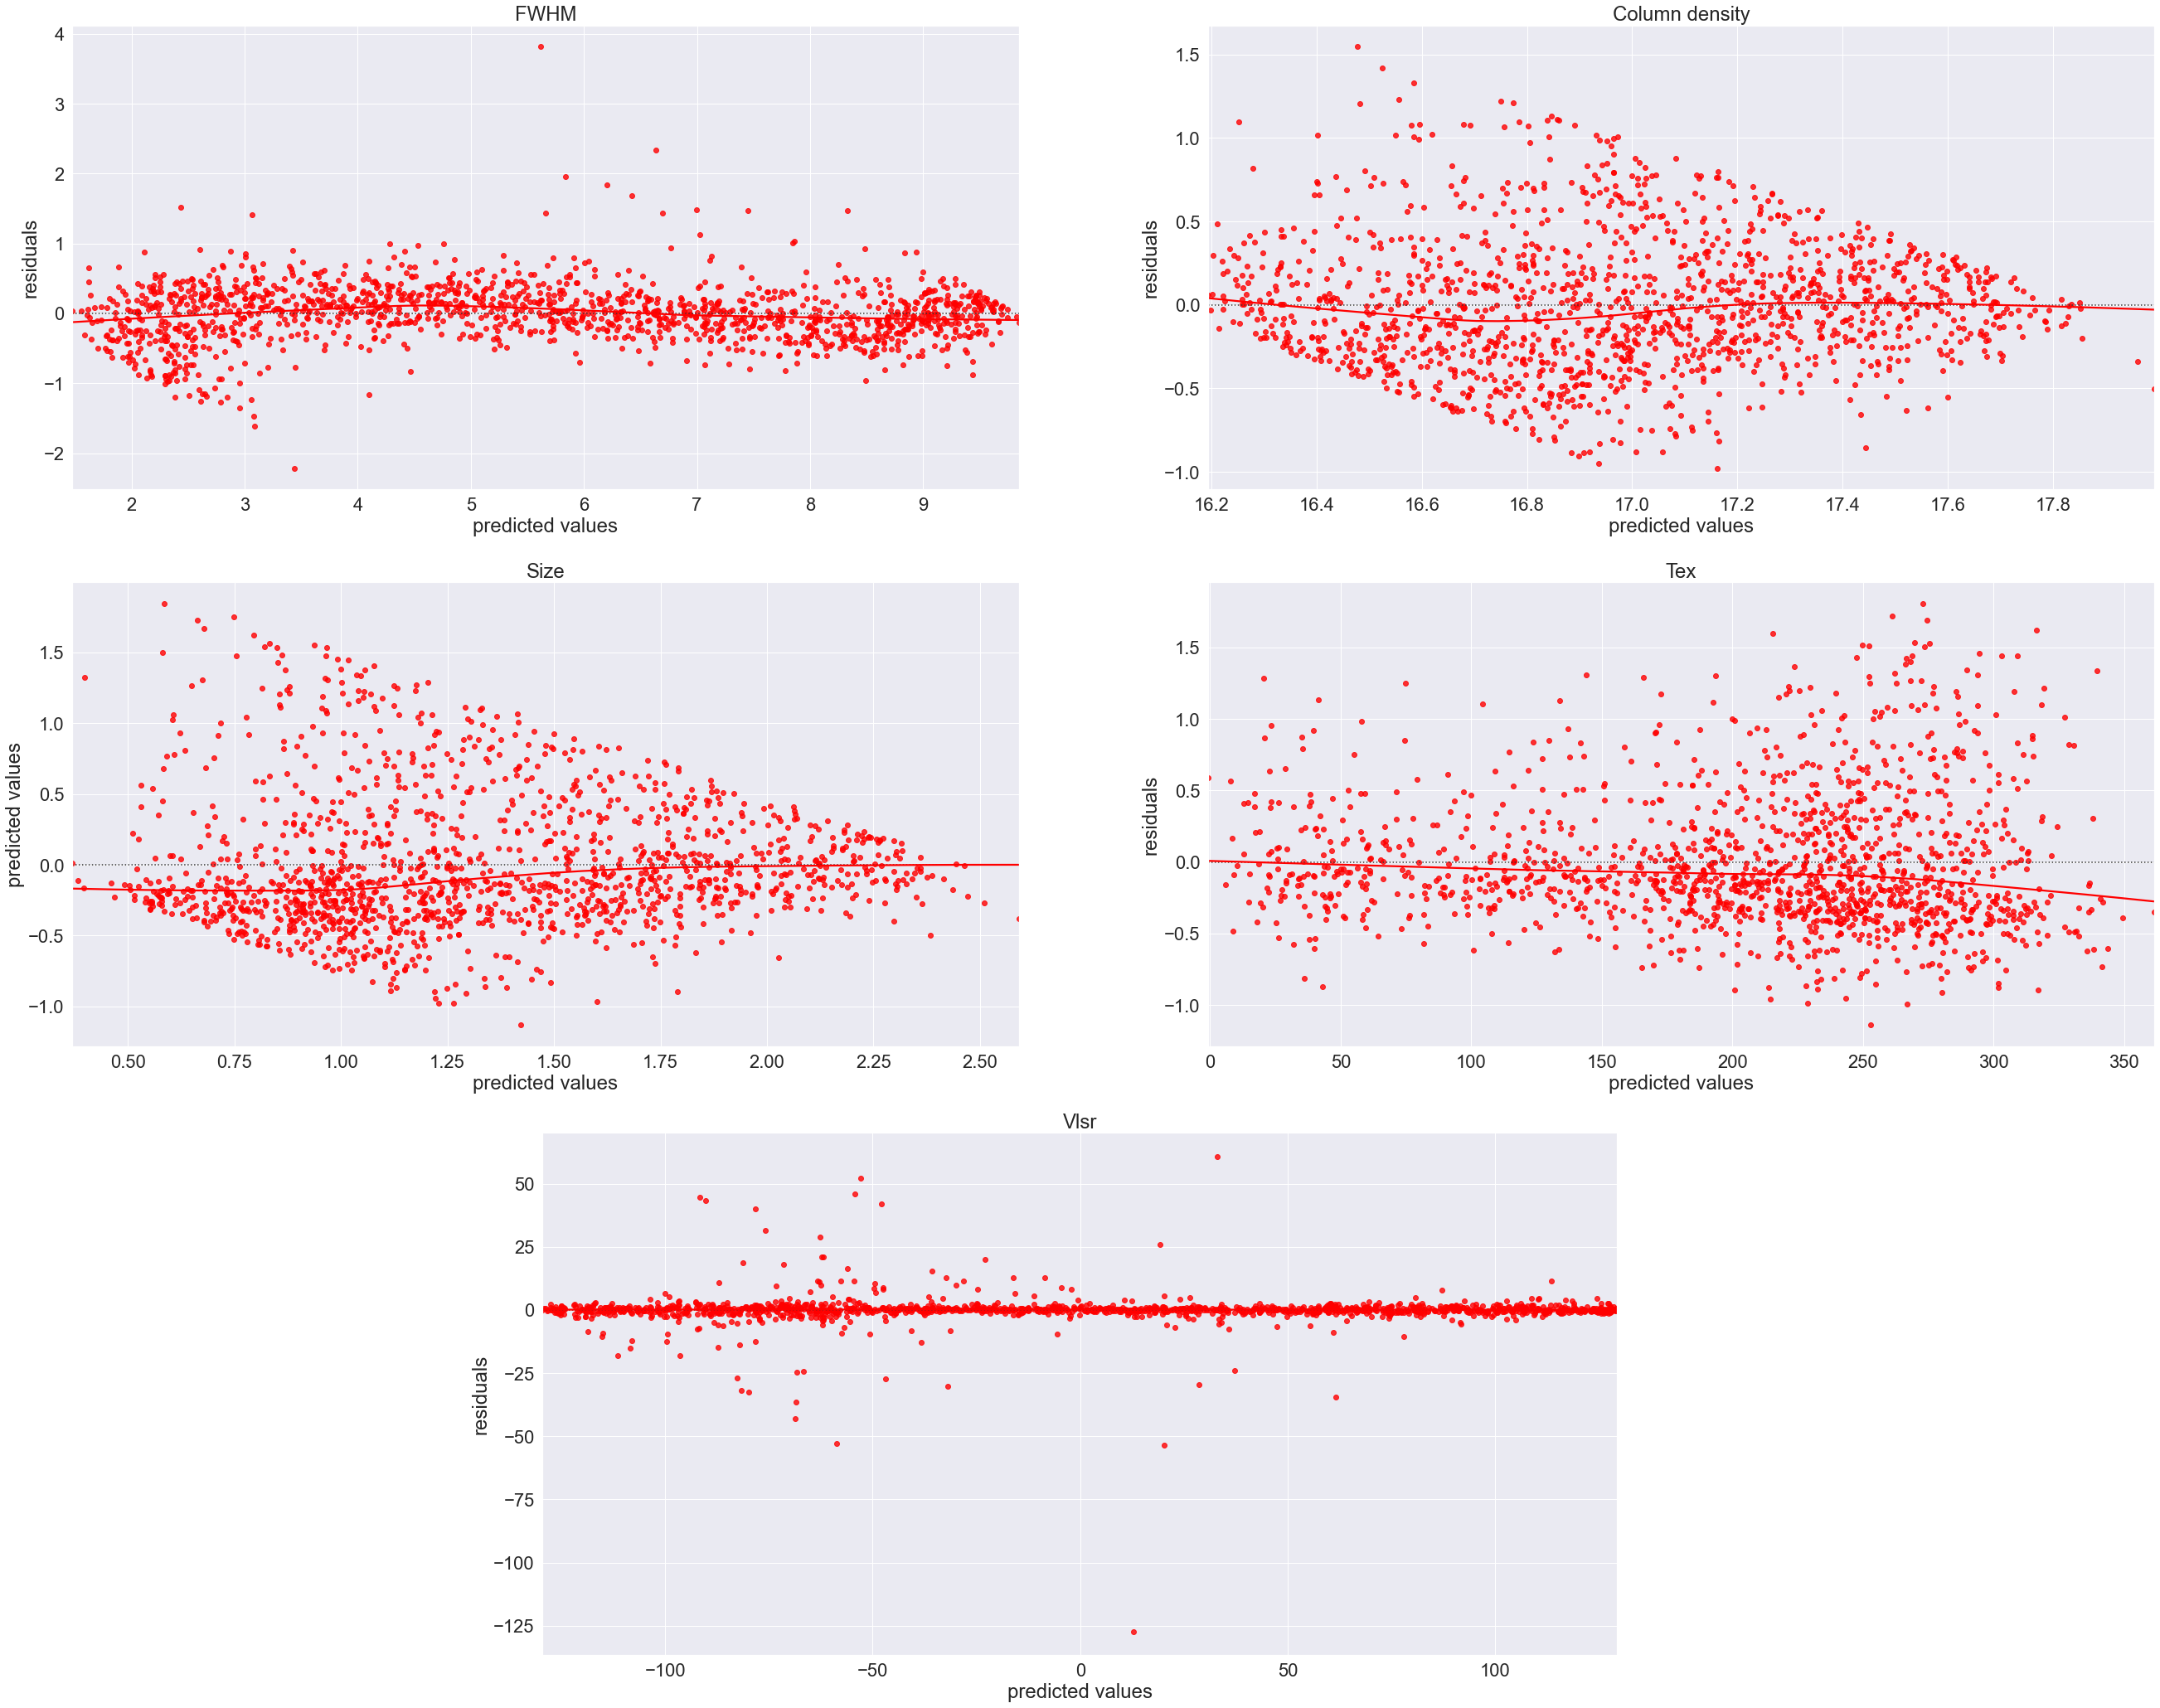

In [64]:
fig, axes = plt.subplots(3, 2, figsize=(45,35))
plt.setp(ax.get_xticklabels(), fontsize=14)
sns.set_theme(font_scale=2) 
axes[2,1].set_visible(False)
axes[2,0].set_position([0.30, 0.1,0.40,0.25])

# plot the redisual distribution using seaborn
g1 = sns.residplot(x=y_multixgb_pred[:,0], y=residuals_xgb['fwhm'], lowess=True, ax=axes[0,0], color='red') # fwhm
g2 = sns.residplot(x=y_multixgb_pred[:,1], y=residuals_xgb['ntot'], lowess=True, ax=axes[0,1], color='red') # column density
g3 = sns.residplot(x=y_multixgb_pred[:,2], y=residuals_xgb['size'], lowess=True, ax=axes[1,0], color='red') # size
g4 = sns.residplot(x=y_multixgb_pred[:,3], y=residuals_xgb['size'], lowess=True, ax=axes[1,1], color='red') # tex
g5 = sns.residplot(x=y_multixgb_pred[:,4], y=residuals_xgb['vlsr'], lowess=True, ax=axes[2,0], color='red') # vlsr

g1.set(title='FWHM', ylabel="residuals", xlabel="predicted values")
g2.set(title='Column density', ylabel="residuals", xlabel="predicted values")
g3.set(title='Size', ylabel="predicted values", xlabel="predicted values")
g4.set(title='Tex', ylabel="residuals", xlabel="predicted values")
g5.set(title='Vlsr', ylabel="residuals", xlabel="predicted values")

plt.savefig("data/5K_gen_files/residuals_XGB_5K.png")
plt.show()